<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 15px; height: 80px">

# Project 3

### Regression and Classification with the Ames Housing Data

---

You have just joined a new "full stack" real estate company in Ames, Iowa. The strategy of the firm is two-fold:
- Own the entire process from the purchase of the land all the way to sale of the house, and anything in between.
- Use statistical analysis to optimize investment and maximize return.

The company is still small, and though investment is substantial the short-term goals of the company are more oriented towards purchasing existing houses and flipping them as opposed to constructing entirely new houses. That being said, the company has access to a large construction workforce operating at rock-bottom prices.

This project uses the [Ames housing data recently made available on kaggle](https://www.kaggle.com/c/house-prices-advanced-regression-techniques).

In [1]:
import numpy as np
import scipy.stats as stats
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

sns.set_style('whitegrid')

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

<img src="http://imgur.com/l5NasQj.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

## 1. Estimating the value of homes from fixed characteristics.

---

Your superiors have outlined this year's strategy for the company:
1. Develop an algorithm to reliably estimate the value of residential houses based on *fixed* characteristics.
2. Identify characteristics of houses that the company can cost-effectively change/renovate with their construction team.
3. Evaluate the mean dollar value of different renovations.

Then we can use that to buy houses that are likely to sell for more than the cost of the purchase plus renovations.

Your first job is to tackle #1. You have a dataset of housing sale data with a huge amount of features identifying different aspects of the house. The full description of the data features can be found in a separate file:

    housing.csv
    data_description.txt
    
You need to build a reliable estimator for the price of the house given characteristics of the house that cannot be renovated. Some examples include:
- The neighborhood
- Square feet
- Bedrooms, bathrooms
- Basement and garage space

and many more. 

Some examples of things that **ARE renovate-able:**
- Roof and exterior features
- "Quality" metrics, such as kitchen quality
- "Condition" metrics, such as condition of garage
- Heating and electrical components

and generally anything you deem can be modified without having to undergo major construction on the house.

---

**Your goals:**
1. Perform any cleaning, feature engineering, and EDA you deem necessary.
- Be sure to remove any houses that are not residential from the dataset.
- Identify **fixed** features that can predict price.
- Train a model on pre-2010 data and evaluate its performance on the 2010 houses.
- Characterize your model. How well does it perform? What are the best estimates of price?

> **Note:** The EDA and feature engineering component to this project is not trivial! Be sure to always think critically and creatively. Justify your actions! Use the data description file!

In [2]:
# Load the data
house = pd.read_csv('./housing.csv')

In [3]:
house.shape

(1460, 81)

In [4]:
house.head(2)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500


In [5]:
house.isnull().ix[:, house.isnull().sum() != 0].sum()

LotFrontage      259
Alley           1369
MasVnrType         8
MasVnrArea         8
BsmtQual          37
BsmtCond          37
BsmtExposure      38
BsmtFinType1      37
BsmtFinType2      38
Electrical         1
FireplaceQu      690
GarageType        81
GarageYrBlt       81
GarageFinish      81
GarageQual        81
GarageCond        81
PoolQC          1453
Fence           1179
MiscFeature     1406
dtype: int64

In [6]:
# Cleaning Alley
print house['Alley'].value_counts(dropna=False)
house['Alley'] = house['Alley'].replace({np.nan: 'None'})
print house['Alley'].value_counts()

NaN     1369
Grvl      50
Pave      41
Name: Alley, dtype: int64
None    1369
Grvl      50
Pave      41
Name: Alley, dtype: int64


In [7]:
# Cleaning MasVnrType and MasVnrArea
print house[house['MasVnrType'].isnull()]['MasVnrArea']
# they are the same rows!
print house['MasVnrType'].value_counts()

# I will drop these 8 rows

house.drop(house[house['MasVnrType'].isnull() == True].index.values, inplace=True)
print house['MasVnrType'].isnull().sum()
print house['MasVnrArea'].isnull().sum()

234    NaN
529    NaN
650    NaN
936    NaN
973    NaN
977    NaN
1243   NaN
1278   NaN
Name: MasVnrArea, dtype: float64
None       864
BrkFace    445
Stone      128
BrkCmn      15
Name: MasVnrType, dtype: int64
0
0


In [8]:
# Cleaning BsmtQual, BsmtCond, BsmtExposure, BsmtFinType1, BsmtFinType2
aux = ['BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2']
print house[house['BsmtExposure'].isnull()][aux]

# They are the same rows! Only 1 has one missing value for the Exposure
for name in aux:
    print house[name].value_counts()
# I erase the 1 without Expusure value and chance the rest to None (refering as No Basement)
house.drop(948, inplace=True)

for name in aux:
    house[name] = house[name].replace({np.nan: 'None'})
    
print house[house['BsmtExposure'].isnull()][aux]

     BsmtQual BsmtCond BsmtExposure BsmtFinType1 BsmtFinType2
17        NaN      NaN          NaN          NaN          NaN
39        NaN      NaN          NaN          NaN          NaN
90        NaN      NaN          NaN          NaN          NaN
102       NaN      NaN          NaN          NaN          NaN
156       NaN      NaN          NaN          NaN          NaN
182       NaN      NaN          NaN          NaN          NaN
259       NaN      NaN          NaN          NaN          NaN
342       NaN      NaN          NaN          NaN          NaN
362       NaN      NaN          NaN          NaN          NaN
371       NaN      NaN          NaN          NaN          NaN
392       NaN      NaN          NaN          NaN          NaN
520       NaN      NaN          NaN          NaN          NaN
532       NaN      NaN          NaN          NaN          NaN
533       NaN      NaN          NaN          NaN          NaN
553       NaN      NaN          NaN          NaN          NaN
646     

In [9]:
# Cleaning Electrical
print house[house['Electrical'].isnull()]

print house['Electrical'].value_counts()

house.drop(house[house['Electrical'].isnull()].index, inplace=True)

print house[house['Electrical'].isnull()]

        Id  MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
1379  1380          80       RL         73.0     9735   Pave  None      Reg   

     LandContour Utilities    ...     PoolArea PoolQC Fence MiscFeature  \
1379         Lvl    AllPub    ...            0    NaN   NaN         NaN   

     MiscVal MoSold YrSold  SaleType  SaleCondition  SalePrice  
1379       0      5   2008        WD         Normal     167500  

[1 rows x 81 columns]
SBrkr    1325
FuseA      94
FuseF      27
FuseP       3
Mix         1
Name: Electrical, dtype: int64
Empty DataFrame
Columns: [Id, MSSubClass, MSZoning, LotFrontage, LotArea, Street, Alley, LotShape, LandContour, Utilities, LotConfig, LandSlope, Neighborhood, Condition1, Condition2, BldgType, HouseStyle, OverallQual, OverallCond, YearBuilt, YearRemodAdd, RoofStyle, RoofMatl, Exterior1st, Exterior2nd, MasVnrType, MasVnrArea, ExterQual, ExterCond, Foundation, BsmtQual, BsmtCond, BsmtExposure, BsmtFinType1, BsmtFinSF1, BsmtFinType2, B

In [10]:
# Cleaning FireplaceQu

print house['FireplaceQu'].value_counts()
# Changing nan to None
house['FireplaceQu'] = house['FireplaceQu'].replace({np.nan:'None'})

print house['FireplaceQu'].isnull().sum()

Gd    378
TA    310
Fa     33
Ex     24
Po     20
Name: FireplaceQu, dtype: int64
0


In [11]:
# Cleaning GarageType, GarageYrBlt, GarageFinish, GarageQual, GarageCond
aux = ['GarageType', 'GarageFinish', 'GarageQual', 'GarageCond']

print house[house['GarageType'].isnull()][aux].sum().sum()
# They are all the same rows!

print house['GarageType'].value_counts()

# I will replace nan to None
for name in aux:
    house[name] = house[name].replace({np.nan: 'None'})
    
print house['GarageType'].isnull().sum()

0.0
Attchd     862
Detchd     387
BuiltIn     86
Basment     19
CarPort      9
2Types       6
Name: GarageType, dtype: int64
0


In [12]:
# Cleaning PoolQC

house['PoolQC'].value_counts()

house['PoolQC'] = house['PoolQC'].replace({np.nan: 'None'})

house['PoolQC'].isnull().sum()

0

In [13]:
# Cleaning Fence
house['Fence'].value_counts()

house['Fence'] = house['Fence'].replace({np.nan: 'None'})

house['Fence'].isnull().sum()

0

In [14]:
# Cleaning MiscFeature
house['MiscFeature'].value_counts()

house['MiscFeature'] = house['MiscFeature'].replace({np.nan: 'None'})

house['MiscFeature'].isnull().sum()

0

In [15]:
# Cleaning LotFrontage
# I will drop this, but i could try to estimate it
print house['LotFrontage'].isnull().sum()
print house.isnull().sum().sum()

house.dropna(inplace=True)

257
338


In [16]:
print house.isnull().sum().sum()
house.shape

0


(1119, 81)

In [17]:
# I will split the 2010 sales in order to test my model later
hs_original = house[house['YrSold'] != 2010].reset_index()
hs_2010_original = house[house['YrSold'] == 2010].reset_index()

In [18]:
# I have my clean data 'hs' to model
hs_original.head()

,index,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,0,1,60,RL,65.0,8450,Pave,None,Reg,Lvl,...,0,None,None,None,0,2,2008,WD,Normal,208500
1,1,2,20,RL,80.0,9600,Pave,None,Reg,Lvl,...,0,None,None,None,0,5,2007,WD,Normal,181500
2,2,3,60,RL,68.0,11250,Pave,None,IR1,Lvl,...,0,None,None,None,0,9,2008,WD,Normal,223500
3,3,4,70,RL,60.0,9550,Pave,None,IR1,Lvl,...,0,None,None,None,0,2,2006,WD,Abnorml,140000
4,4,5,60,RL,84.0,14260,Pave,None,IR1,Lvl,...,0,None,None,None,0,12,2008,WD,Normal,250000


In [19]:
# I will be working on copies
hs = hs_original.copy()
hs_2010 = hs_2010_original.copy()

count    987.000000
mean     185.720065
std       82.554635
min       35.311000
25%      131.450000
50%      165.000000
75%      219.750000
max      755.000000
Name: SalePrice, dtype: float64


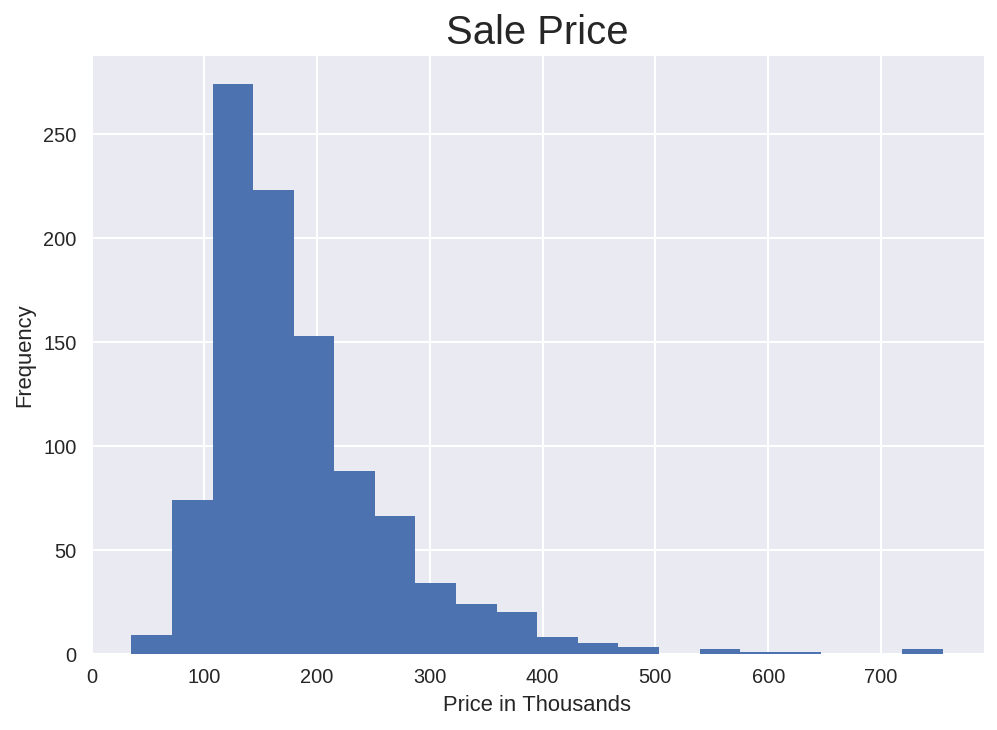

In [26]:
#############
#    EDA    #
#############
sns.set(font_scale=1)

(hs['SalePrice']/1000).hist(bins=20)
plt.title("Sale Price", fontsize=20)
plt.xlabel("Price in Thousands")
plt.ylabel("Frequency")
print (hs['SalePrice']/1000).describe()

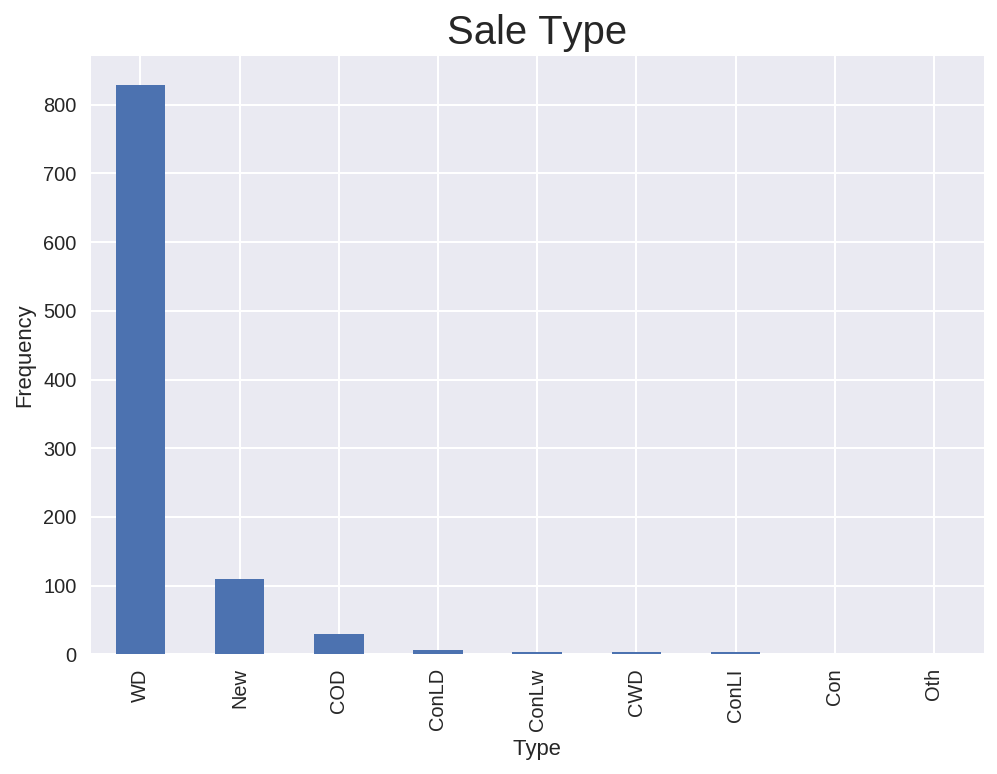

In [27]:
hs['SaleType'].value_counts().plot(kind='bar')
plt.title("Sale Type", fontsize=20)
plt.xlabel("Type")
plt.ylabel("Frequency")

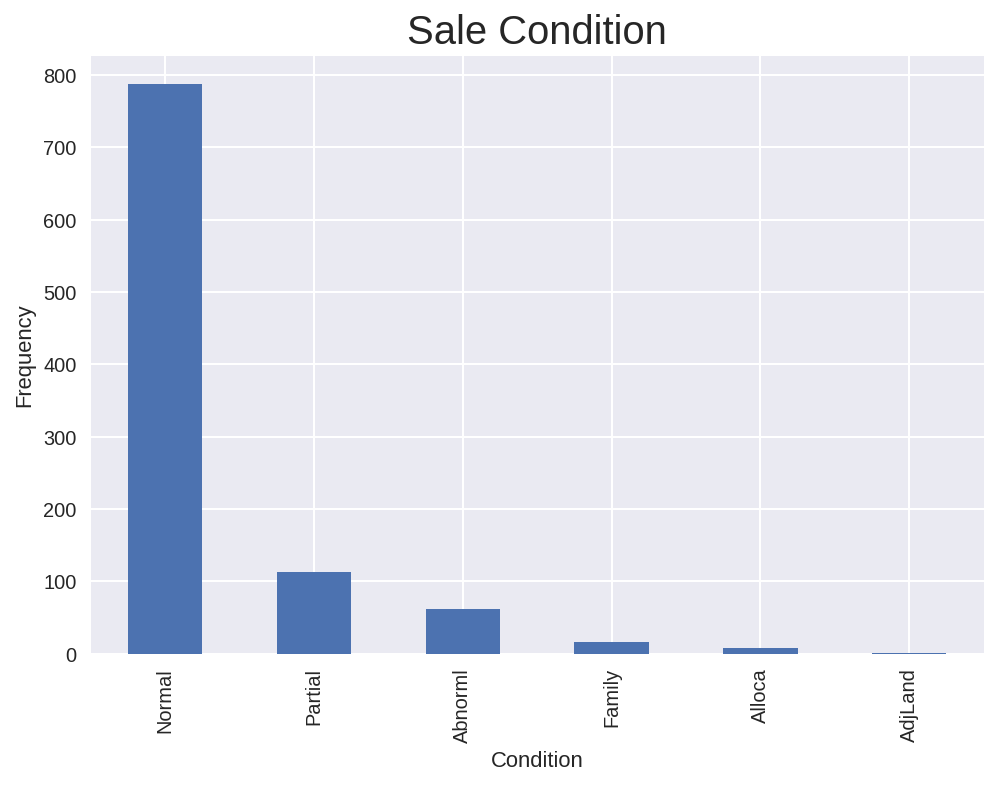

In [28]:
hs['SaleCondition'].value_counts().plot(kind='bar')
plt.title("Sale Condition", fontsize=20)
plt.xlabel("Condition")
plt.ylabel("Frequency")

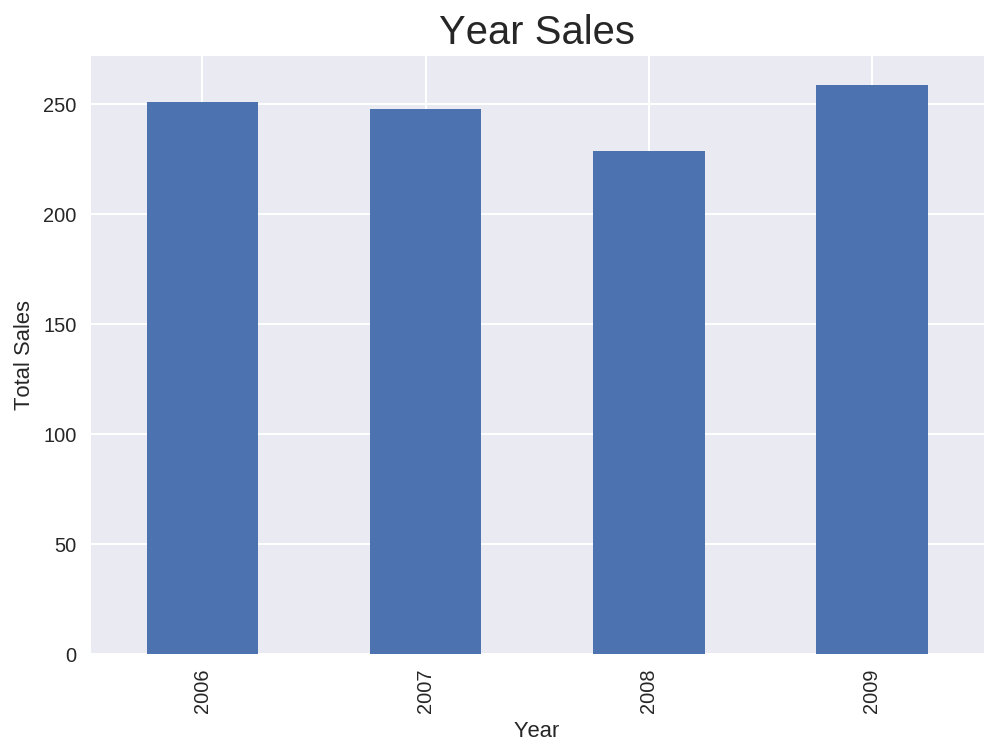

In [29]:
hs['YrSold'].value_counts().sort_index().plot(kind='bar')
plt.title("Year Sales", fontsize=20)
plt.xlabel("Year")
plt.ylabel("Total Sales")

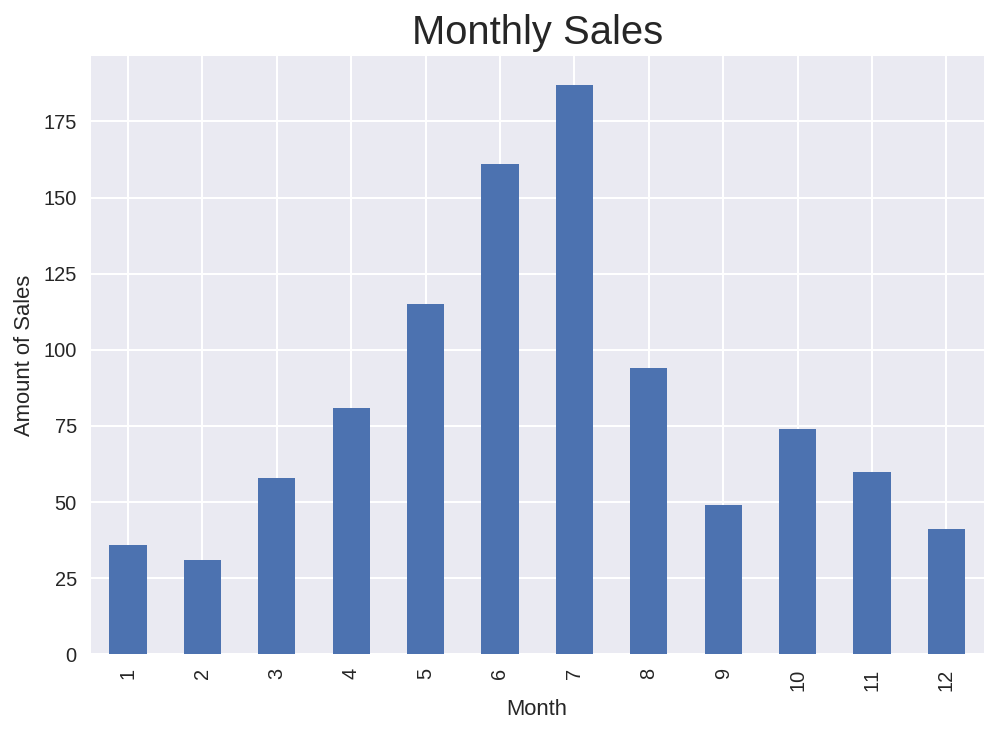

In [30]:
hs['MoSold'].value_counts().sort_index().plot(kind='bar')
plt.title("Monthly Sales", fontsize=20)
plt.xlabel("Month")
plt.ylabel("Amount of Sales")

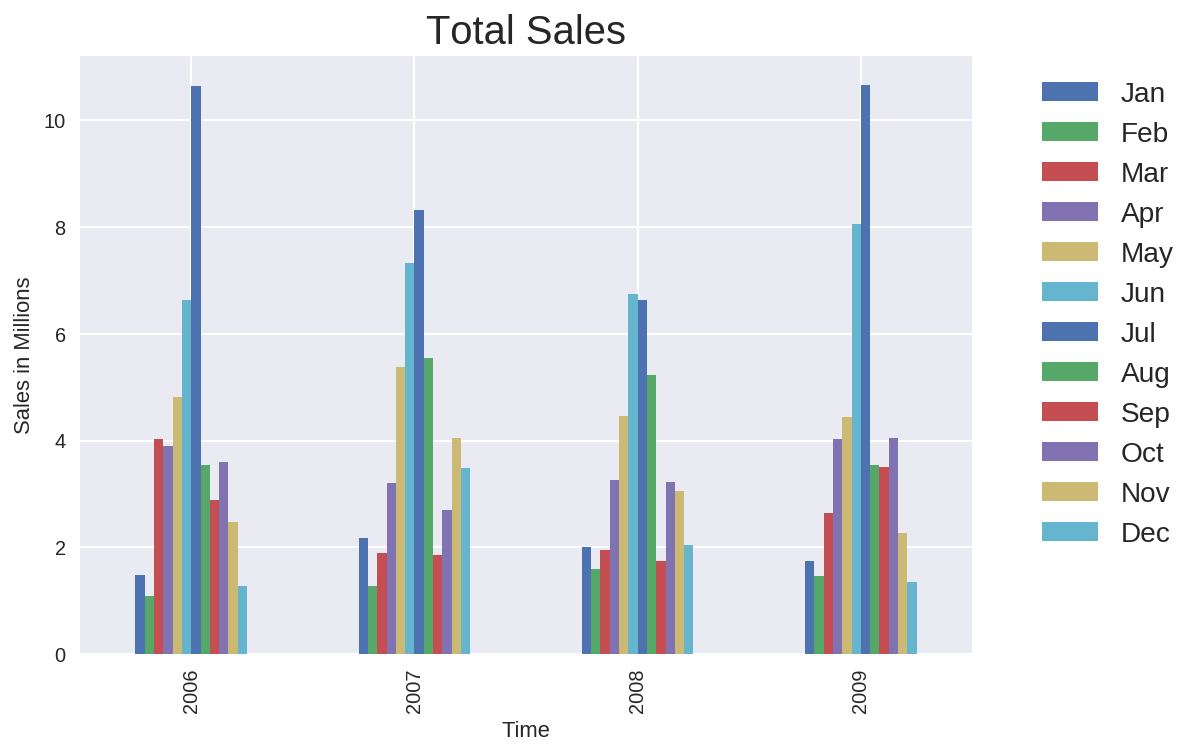

In [43]:
months = ['Jan', 'Feb', 'Mar', 'Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']
(hs.groupby(['YrSold', 'MoSold'])['SalePrice'].sum()/1000000).unstack().plot(kind='bar')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, labels=months, fontsize=14)
plt.title("Total Sales", fontsize=20)
plt.xlabel("Time")
plt.ylabel("Sales in Millions")

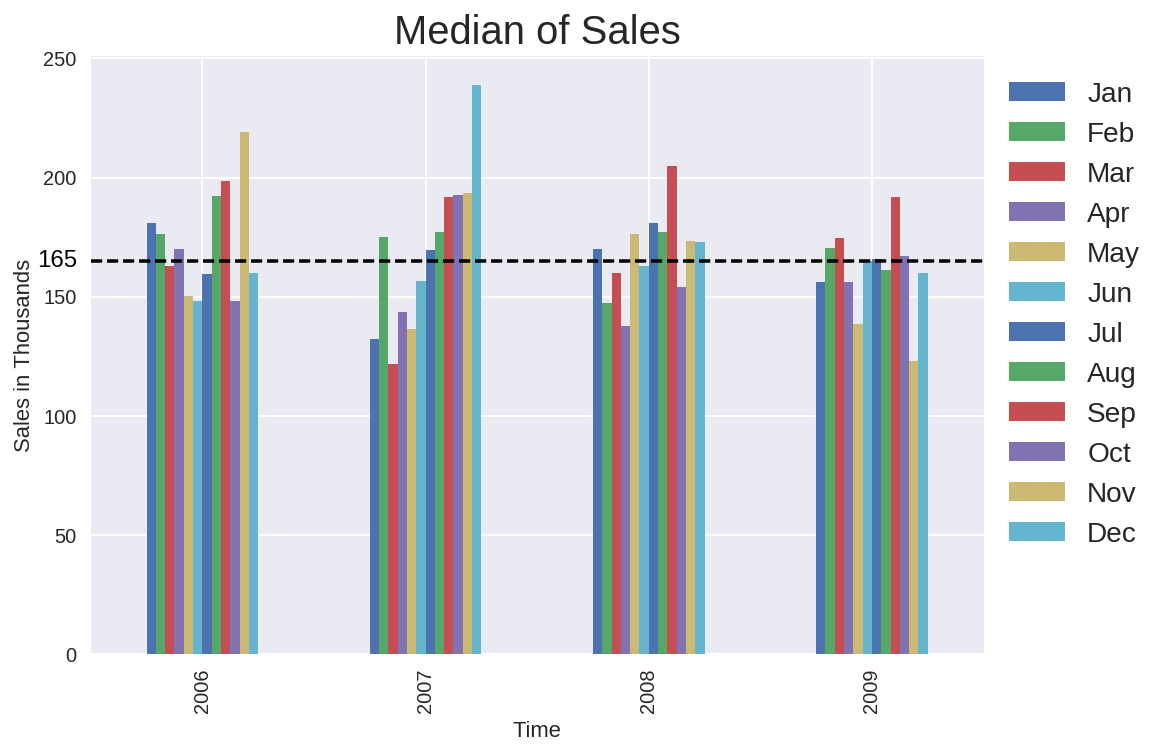

In [44]:
import matplotlib.transforms as transforms
(hs.groupby(['YrSold', 'MoSold'])['SalePrice'].median()/1000).unstack().plot(kind='bar')
plt.legend(bbox_to_anchor=(1, 1), loc=2, labels=months, fontsize=14)
plt.title("Median of Sales", fontsize=20)
plt.xlabel("Time")
plt.ylabel("Sales in Thousands")
ax = plt.gca()
sales_median = hs['SalePrice'].median()/1000
ax.axhline(y=sales_median, c='black', linestyle='--')
trans = transforms.blended_transform_factory(ax.get_yticklabels()[0].get_transform(),\
                                             ax.transData)
ax.text(0,sales_median, "{:.0f}".format(sales_median), color="black", transform=trans, 
        ha="right", va="center")

In [31]:
################
# Categorizing #
################
categorical_columns = hs.select_dtypes(include=['object']).columns.values
for c in categorical_columns:
    hs[c] = hs[c].astype('category').cat.codes

In [67]:
def split_years(hs):
    hs_remodeled = hs[hs['YearBuilt'] != hs['YearRemodAdd']]
    hs_nremodeled = hs[hs['YearBuilt'] == hs['YearRemodAdd']]
    y_remodeled = hs_remodeled['SalePrice'].values
    y_nremodeled = hs_nremodeled['SalePrice'].values
    # All columns but index, Id and SalePrice
    X_remodeled = hs_remodeled[[c for c in hs.columns.values\
                                if c not in ['SalePrice', 'index', 'Id', 'MoSold']]]
    X_nremodeled = hs_nremodeled[[c for c in hs.columns.values\
                                  if c not in ['SalePrice', 'index', 'Id', 'MoSold']]]

    X_remodeled = X_remodeled.reset_index()
    X_nremodeled = X_nremodeled.reset_index()
    
    return X_remodeled, X_nremodeled, y_remodeled, y_nremodeled

X_remodeled, X_nremodeled, y_remodeled, y_nremodeled = split_years(hs)



In [68]:
# Two df:
baseprice = ['MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street', 'Alley', \
             'LotShape', 'LandContour', 'LotConfig', 'LandSlope', 'Neighborhood', \
             'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'YearBuilt', \
             'YearRemodAdd', 'RoofStyle', 'Foundation', 'BsmtQual', 'BsmtExposure', \
             'Heating', 'CentralAir', '1stFlrSF', '2ndFlrSF', 'GrLivArea', 'BsmtFullBath',\
             'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', \
             'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'GarageType', 'GarageYrBlt', \
             'GarageCars', 'GarageArea', 'GarageQual', 'PavedDrive', 'WoodDeckSF', \
             'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', \
             'Fence', 'MiscFeature', 'MiscVal', 'SaleType']

improvements = ['Utilities', 'OverallQual', 'OverallCond', 'RoofMatl', 'Exterior1st',\
                'Exterior2nd', 'MasVnrType', 'MasVnrArea', 'ExterQual', 'ExterCond', \
                'BsmtCond', 'BsmtFinType1', 'BsmtFinSF1', 'BsmtFinType2', 'BsmtFinSF2', \
                'BsmtUnfSF', 'TotalBsmtSF', 'HeatingQC', 'Electrical', 'LowQualFinSF', \
                'KitchenQual', 'FireplaceQu', 'GarageFinish', 'GarageCond', 'PoolQC']


In [69]:
print hs.shape, X_remodeled.shape, X_nremodeled.shape
"""
As SalePrice is a continuos variable I will use a regressor model:
    - MLR (Risso, Lasso, Elastic)
    - KNN Regressor
    
Plan:
- Standarize with StandardScaler
- Feature Selection using LassoCV
- Hyperparameter for models
"""

(987, 82) (477, 79) (510, 79)


'\nAs SalePrice is a continuos variable I will use a regressor model:\n    - MLR (Risso, Lasso, Elastic)\n    - KNN Regressor\n    \nPlan:\n- Standarize with StandardScaler\n- Feature Selection using LassoCV\n- Hyperparameter for models\n'

In [70]:
##############
# Standarize #
##############

from sklearn.preprocessing import StandardScaler

ss = StandardScaler()

Xs_nremodeled = ss.fit_transform(X_nremodeled)

In [71]:
##################
# Regularization #
##################

from sklearn.linear_model import Lasso
from sklearn.model_selection import cross_val_score

def cross_validator(l, X,y, alphas=None, cv=5):
    if alphas is None:
        alphas = np.linspace(1,3000,500)
    scores = []
    coef = []
    for i,alpha in enumerate(alphas):
        if not (float(i)/len(alphas)*100 % 10):
            print float(i)/len(alphas)*100 + 10
        l.set_params(alpha=alpha)
        l.fit(X,y)
        scores_cv = cross_val_score(l,X, y, cv=5)
        score = scores_cv.mean()
        scores.append(score)
        coef.append(l.coef_)
    return scores, coef

alphas = np.linspace(1,3000,500)
ls = Lasso(max_iter=5000)
scores, coef = cross_validator(ls, Xs_nremodeled,y_nremodeled,cv=5)

10.0
20.0
30.0
40.0
50.0
60.0
70.0
80.0
90.0
100.0


0.748854500979 1828.0


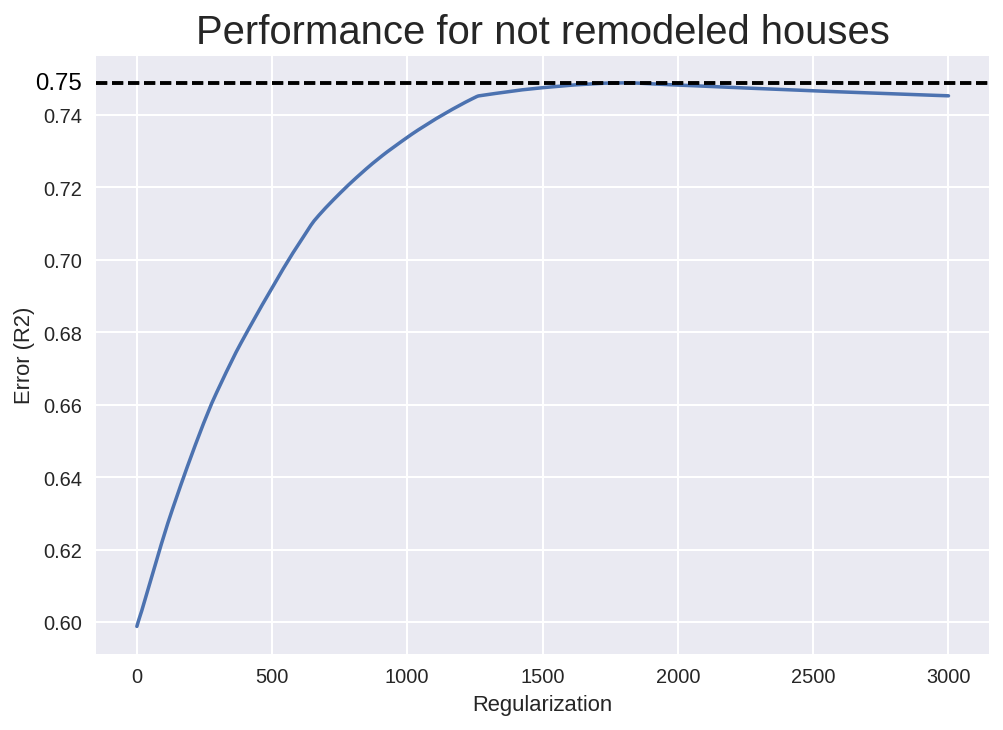

In [73]:
# Scores plot
plt.plot(alphas,scores)
ax = plt.gca()
ax.axhline(y=max(scores), c='black', linestyle='--')
max_alpha = round(alphas[scores.index(max(scores))])
max_score = max(scores)
plt.title("Performance for not remodeled houses", fontsize=20)
plt.xlabel("Regularization")
plt.ylabel("Error (R2)")
ax = plt.gca()
ax.axhline(y=max_score, c='black', linestyle='--')
trans = transforms.blended_transform_factory(ax.get_yticklabels()[0].get_transform(),\
                                             ax.transData)
ax.text(0,max_score, "{:.2f}".format(max_score), color="black", transform=trans, 
        ha="right", va="center")

print max_score, max_alpha

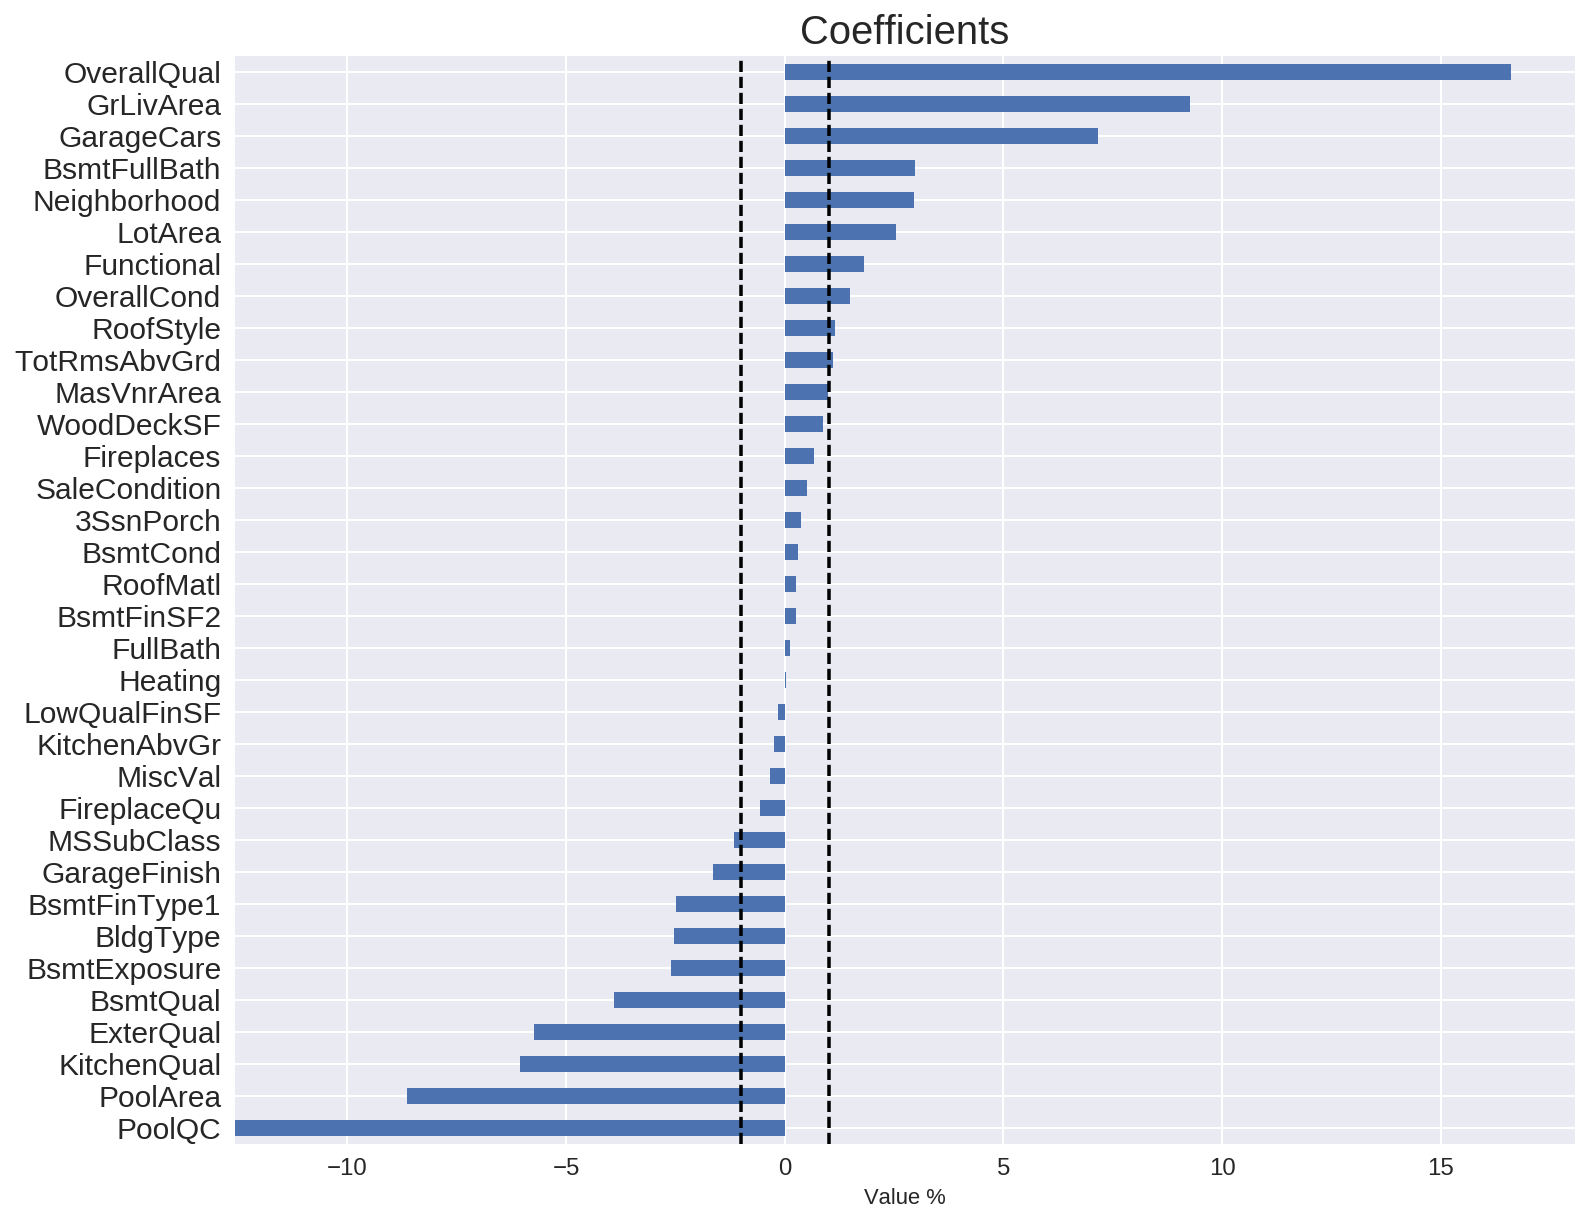

In [74]:
# Coefficients for alpha = max_alpha and different from cero
df_coef = pd.DataFrame(coef, columns=X_nremodeled.columns)
plt.figure(figsize=(12,10))

max_score_index = scores.index(max_score)
max_coef = df_coef.ix[max_score_index,df_coef.ix[max_score_index,:] != 0]
max_coef_normalized = 100*max_coef / sum(abs(max_coef))

max_coef_normalized.sort_values().plot(kind='barh')
plt.yticks(fontsize=15)
plt.xticks(fontsize=12)
plt.title("Coefficients", fontsize=20)
plt.xlabel("Value %")
ax = plt.gca()
ax.axvline(x=1, c='black', linestyle='--')
ax.axvline(x=-1, c='black', linestyle='--')

['OverallQual' 'GrLivArea' 'GarageCars' 'BsmtFullBath' 'Neighborhood'
 'LotArea' 'Functional' 'OverallCond' 'RoofStyle' 'TotRmsAbvGrd'
 'MSSubClass' 'GarageFinish' 'BsmtFinType1' 'BldgType' 'BsmtExposure'
 'BsmtQual' 'ExterQual' 'KitchenQual' 'PoolArea' 'PoolQC'] 20


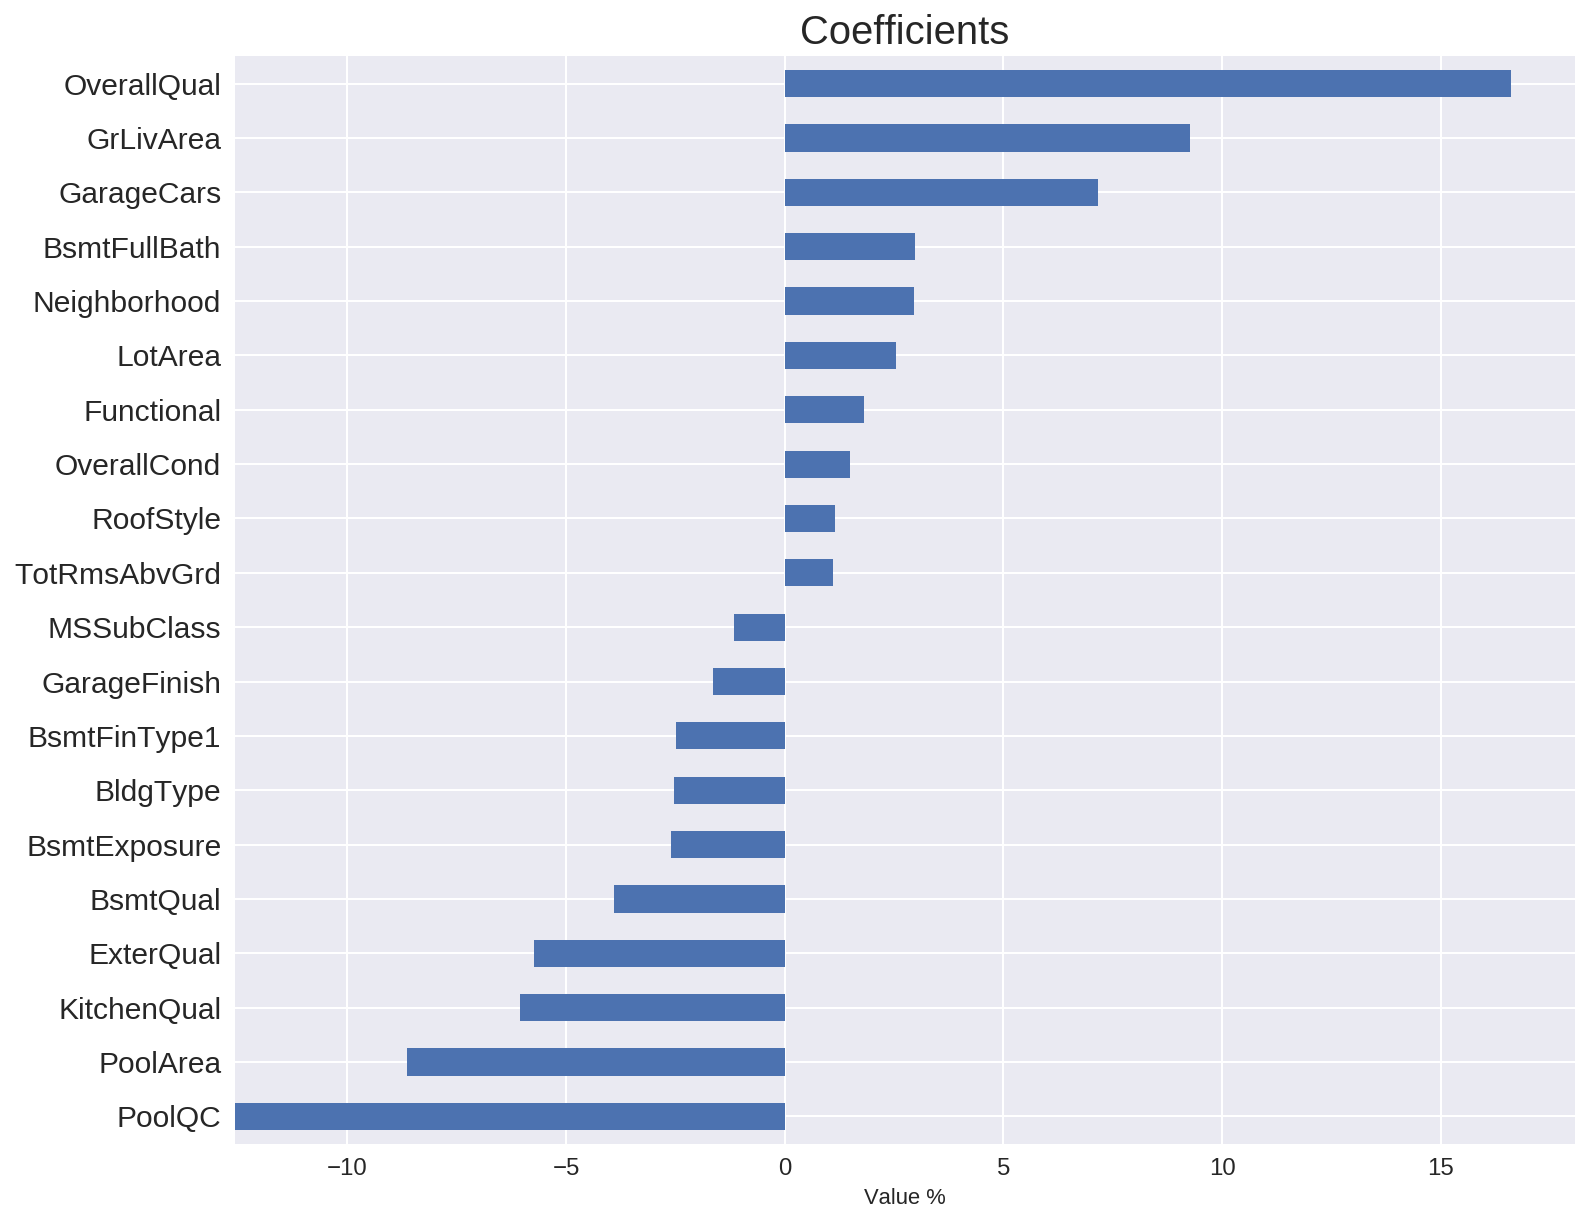

In [75]:
# I keep the coefficients with more influence that 5%
plt.figure(figsize=(12,10))

df_filtered = max_coef_normalized[(abs(max_coef_normalized) > 1)]

df_filtered.sort_values().plot(kind='barh')
plt.yticks(fontsize=15)
plt.xticks(fontsize=12)
plt.title("Coefficients", fontsize=20)
plt.xlabel("Value %")

baseprice_important = df_filtered.sort_values(ascending=False).index.values
print baseprice_important, len(baseprice_important)

In [76]:
X_nremodeled_reduced = X_nremodeled[baseprice_important]
print X_nremodeled.shape, X_nremodeled_reduced.shape

(510, 79) (510, 20)


In [77]:
Xs_nremodeled_reduced = ss.fit_transform(X_nremodeled_reduced)

In [78]:
from sklearn.linear_model import ElasticNet
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import RFE
from sklearn.pipeline import Pipeline

el = ElasticNet(max_iter=2000)
params = {
    'alpha': np.linspace(100,1000,100),
    'l1_ratio': np.linspace(0,1,10)
}

gs = GridSearchCV(el, params, cv=5)

gs.fit(Xs_nremodeled_reduced,y_nremodeled)

GridSearchCV(cv=5, error_score='raise',
       estimator=ElasticNet(alpha=1.0, copy_X=True, fit_intercept=True, l1_ratio=0.5,
      max_iter=2000, normalize=False, positive=False, precompute=False,
      random_state=None, selection='cyclic', tol=0.0001, warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'alpha': array([  100.     ,   109.09091, ...,   990.90909,  1000.     ]), 'l1_ratio': array([ 0.     ,  0.11111,  0.22222,  0.33333,  0.44444,  0.55556,
        0.66667,  0.77778,  0.88889,  1.     ])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

In [79]:
from sklearn.linear_model import ElasticNet
from sklearn.model_selection import cross_val_score

# Training for best parameters
print gs.best_params_, gs.best_score_

best_el = ElasticNet(alpha=gs.best_params_['alpha'], l1_ratio=gs.best_params_['l1_ratio'])
cross_val_score(best_el, Xs_nremodeled_reduced,y_nremodeled,cv=5).mean()

{'alpha': 1000.0, 'l1_ratio': 1.0} 0.786741965053


0.78674196505259331

In [80]:
# l1_ratio = 1 is Lasso
# Re-train for lasso  (won't change anything) - Replace for the elastic training beore
ls_d = Lasso()
scores_el, coef_el = cross_validator(ls_d, Xs_nremodeled_reduced,y_nremodeled, cv=5)

10.0
20.0
30.0
40.0
50.0
60.0
70.0
80.0
90.0
100.0


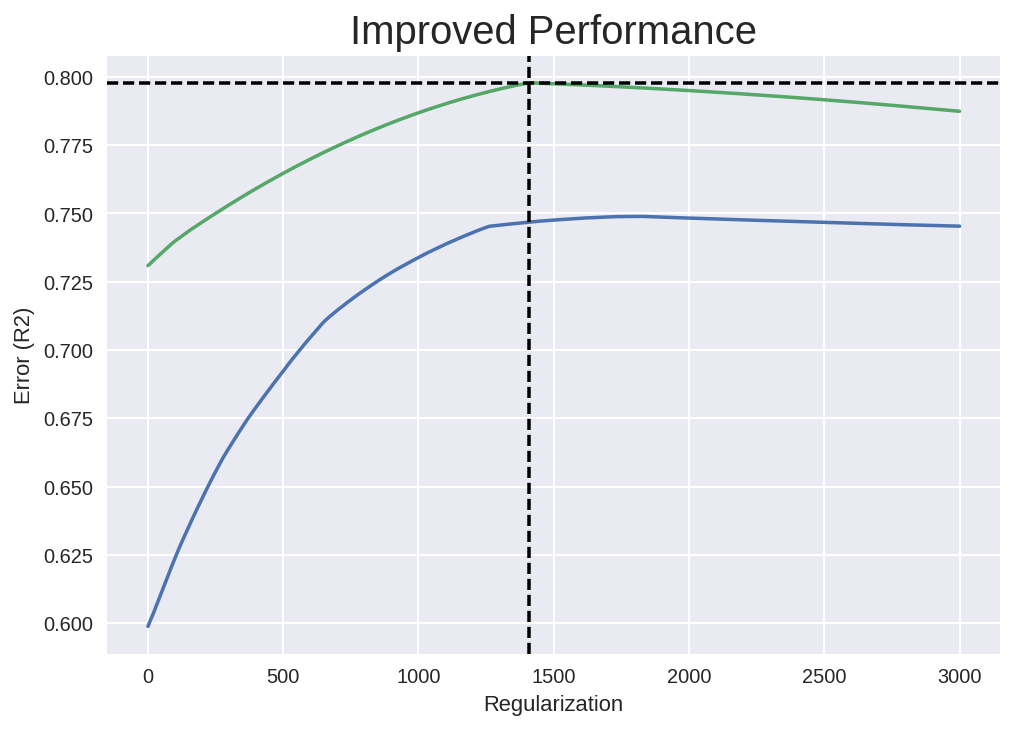

In [85]:
# Scores plot
plt.plot(alphas,scores)
plt.plot(alphas,scores_el)
ax = plt.gca()
el_best_alpha = alphas[scores_el.index(max(scores_el))]
ax.axvline(x=el_best_alpha, c='black', linestyle='--')

plt.title("Improved Performance", fontsize=20)
plt.xlabel("Regularization")
plt.ylabel("Error (R2)")
ax = plt.gca()
ax.axhline(y=max(scores_el), c='black', linestyle='--')

#print max(scores)

In [86]:
# Train Lasso with the best parameters
ls_d.set_params(alpha=el_best_alpha)
ls_d.fit(Xs_nremodeled_reduced, y_nremodeled)

Lasso(alpha=1407.3446893787575, copy_X=True, fit_intercept=True,
   max_iter=1000, normalize=False, positive=False, precompute=False,
   random_state=None, selection='cyclic', tol=0.0001, warm_start=False)

In [162]:
ls_d.coef_

array([ 22280.56002287,  13283.44165921,   9454.51565316,   4345.69823868,
         4236.955978  ,   4273.80916328,   2467.97123414,   2946.14784885,
         2071.64116047,   1508.47082353,   2018.45982327,   1593.45241009,
        -1806.37279831,  -3241.505876  ,  -3674.76601922,  -4102.65868357,
        -4214.74264395,  -5525.38061379,  -8224.13979634,  -8704.18213756,
       -17416.57272729, -22263.14685821])

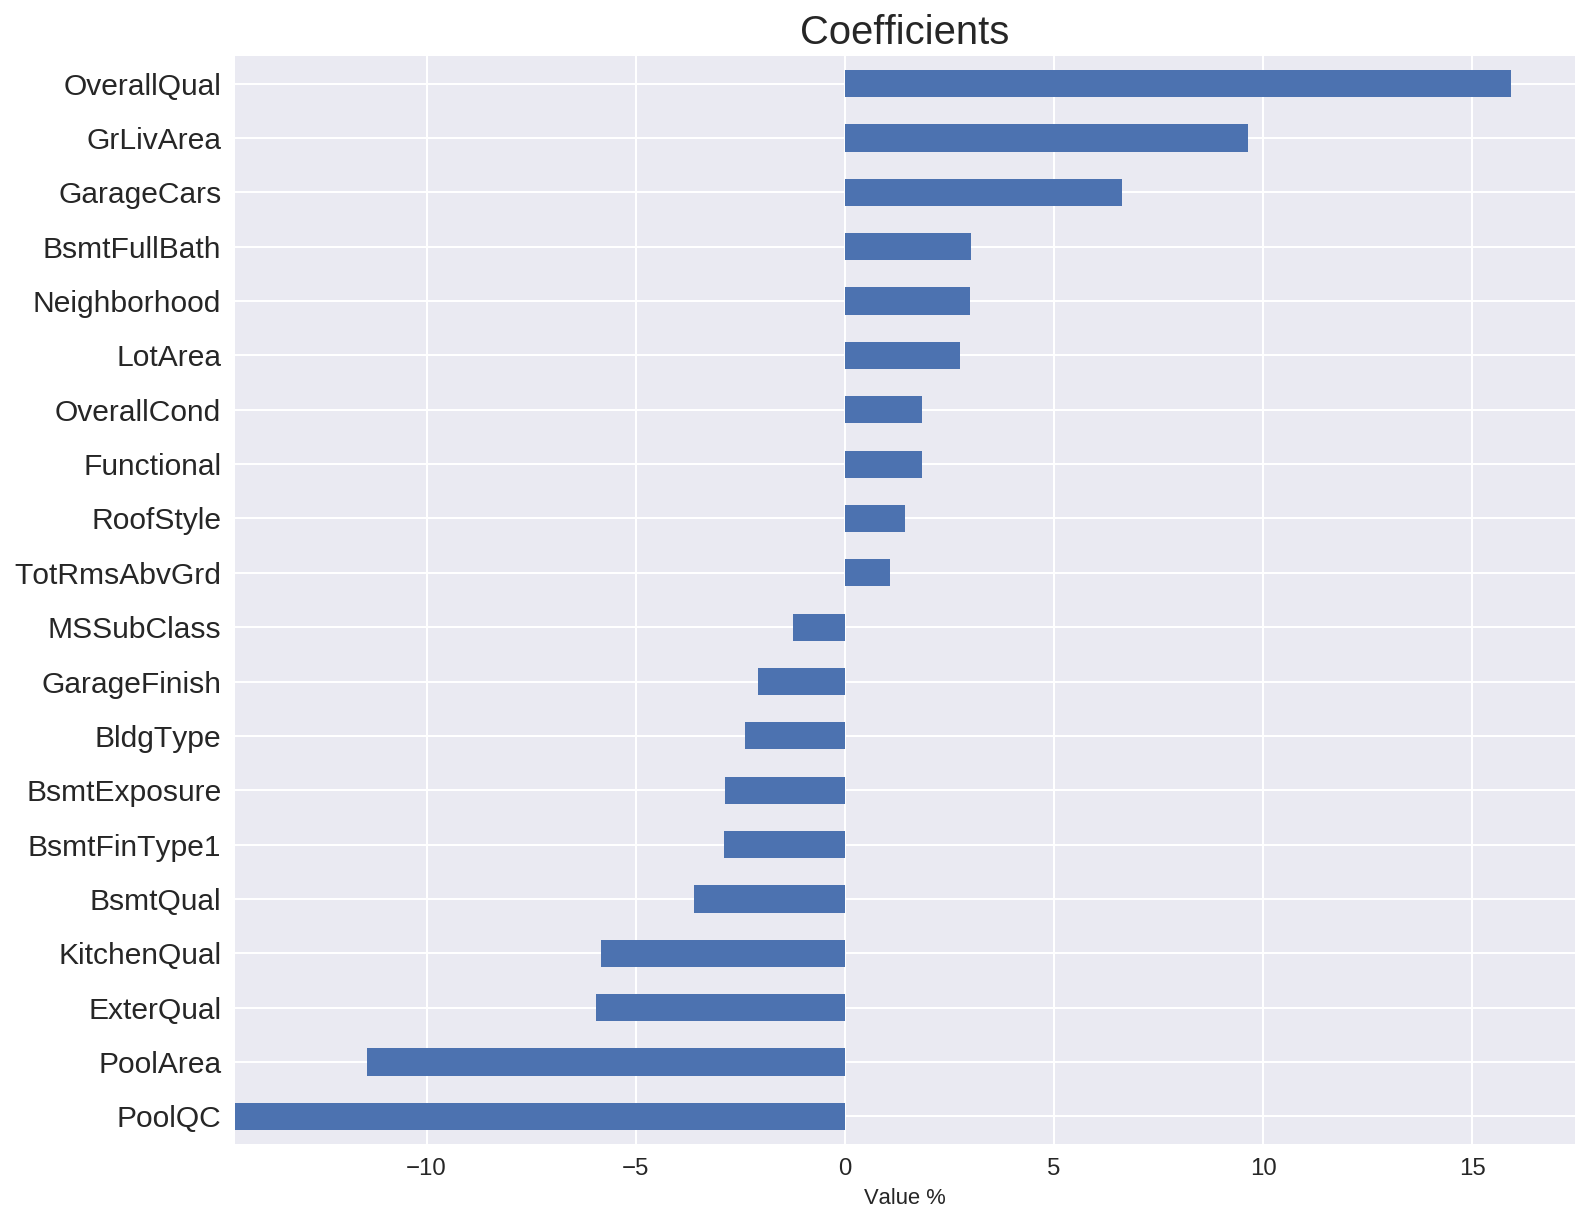

In [91]:
# Plot Coeficients
el_max_score_index = scores_el.index(max(scores_el))
df_coef_el = pd.Series(dict(zip(baseprice_important, ls_d.coef_)))
#print df_coef_el/(sum(abs(df_coef_el)))
el_df_coef = df_coef_el
el_df_coef_normalized = 100*el_df_coef/(sum(abs(el_df_coef)))

plt.figure(figsize=(12,10))
el_df_coef_normalized.sort_values().plot(kind='barh')
plt.yticks(fontsize=15)
plt.xticks(fontsize=12)
plt.title("Coefficients", fontsize=20)
plt.xlabel("Value %")

In [87]:
cross_val_score(ls_d, Xs_nremodeled_reduced,y_nremodeled, cv=5).mean()

0.79771685711121476

In [93]:
y_predicted = ls_d.predict(Xs_nremodeled_reduced)

29.0815085504


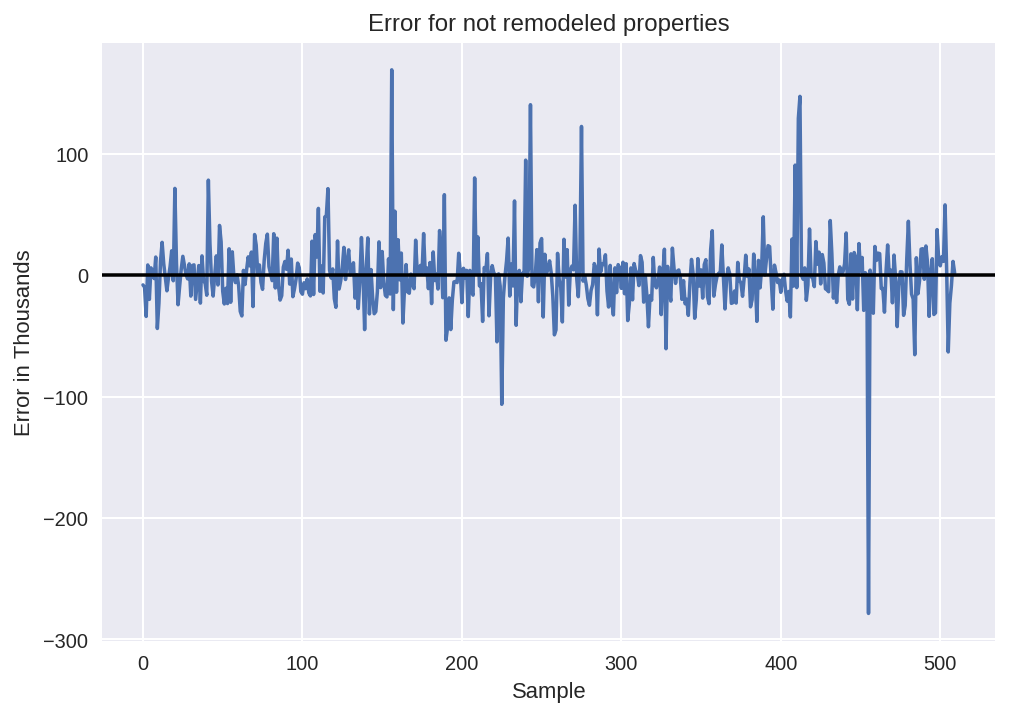

In [107]:
# Plot not remodeled error
plt.plot((y_nremodeled - y_predicted)/1000)
plt.title("Error for not remodeled properties")
plt.xlabel("Sample")
plt.ylabel("Error in Thousands")
ax = plt.gca()

ax.axhline(y=(y_nremodeled - y_predicted).mean()/1000, color='black')
print (y_nremodeled - y_predicted).std()/1000
#axes.set_xlim([xmin,xmax])
#axes.set_ylim([ymin,ymax])

In [149]:
# Save columns used and pick those columns from my remodeled data frame
improvement_important = el_df_coef.index.values
X_remodeled_fix = X_remodeled[improvement_important]

In [152]:
print X_remodeled_fix.shape, Xs_nremodeled_reduced.shape

(477, 20) (510, 20)


In [150]:
# Standarized the remodeled data
Xs_remodeled_fix = ss.fit_transform(X_remodeled_fix)

In [151]:
# Predict the remodeled data based on the not remodeled
y_remodeled_predicted = ls_d.predict(Xs_remodeled_fix)

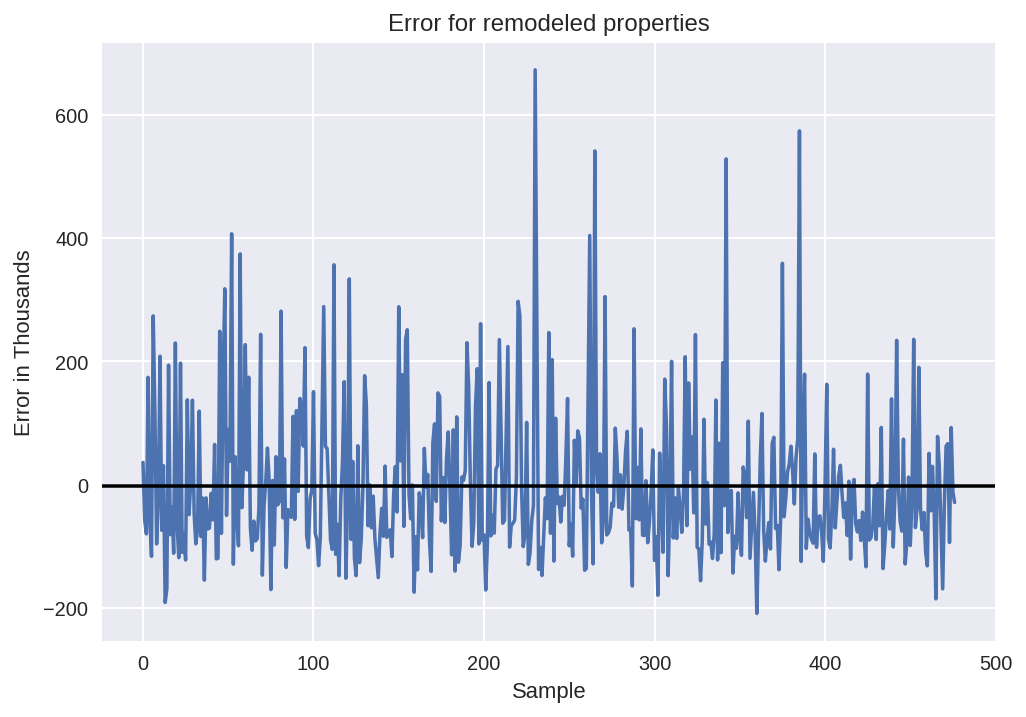

In [153]:
# Plot error
plt.plot((y_remodeled - y_remodeled_predicted)/1000)

plt.title("Error for remodeled properties")
plt.xlabel("Sample")
plt.ylabel("Error in Thousands")
ax = plt.gca()

ax.axhline(y=(y_remodeled - y_remodeled_predicted).mean()/1000, color='black')


In [162]:
# Add base price as a new column
X_remodeled_fix = pd.concat([X_remodeled[improvements],pd.DataFrame(y_remodeled_predicted, columns=['predicted'])],\
                            axis=1)
#X_remodeled_fix = pd.concat([X_remodeled_fix,pd.DataFrame(y_remodeled_predicted, columns=['predicted'])],\
#                            axis=1)

In [163]:
print X_remodeled_fix.shape
print pd.DataFrame(y_remodeled_predicted, columns=['predicted']).shape

(477, 26)
(477, 1)


In [164]:
# Standarized data frame (with the 'price' new column)
Xs_remodeled_fix_full = ss.fit_transform(X_remodeled_fix)

In [165]:
# Finde best parameters for model, where the output is the added price
y_diff = y_remodeled - y_remodeled_predicted

el_2 = ElasticNet(max_iter=2000)
params = {
    'alpha': np.linspace(500,10000,100),
    'l1_ratio': np.linspace(0,1,10)
}

gs_2 = GridSearchCV(el_2, params, cv=5)

gs_2.fit(Xs_remodeled_fix_full,y_diff)

GridSearchCV(cv=5, error_score='raise',
       estimator=ElasticNet(alpha=1.0, copy_X=True, fit_intercept=True, l1_ratio=0.5,
      max_iter=2000, normalize=False, positive=False, precompute=False,
      random_state=None, selection='cyclic', tol=0.0001, warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'alpha': array([   500.    ,    595.9596, ...,   9904.0404,  10000.    ]), 'l1_ratio': array([ 0.     ,  0.11111,  0.22222,  0.33333,  0.44444,  0.55556,
        0.66667,  0.77778,  0.88889,  1.     ])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

In [166]:
print gs_2.best_params_, gs_2.best_score_

# Retrain with best parameters
best_el = ElasticNet(alpha=gs_2.best_params_['alpha'], l1_ratio=gs_2.best_params_['l1_ratio'])
best_el.fit(Xs_remodeled_fix_full,y_diff)
cross_val_score(best_el, Xs_remodeled_fix_full,y_diff,cv=5).mean()

{'alpha': 1459.5959595959596, 'l1_ratio': 1.0} 0.883013771443


0.8830559757311246

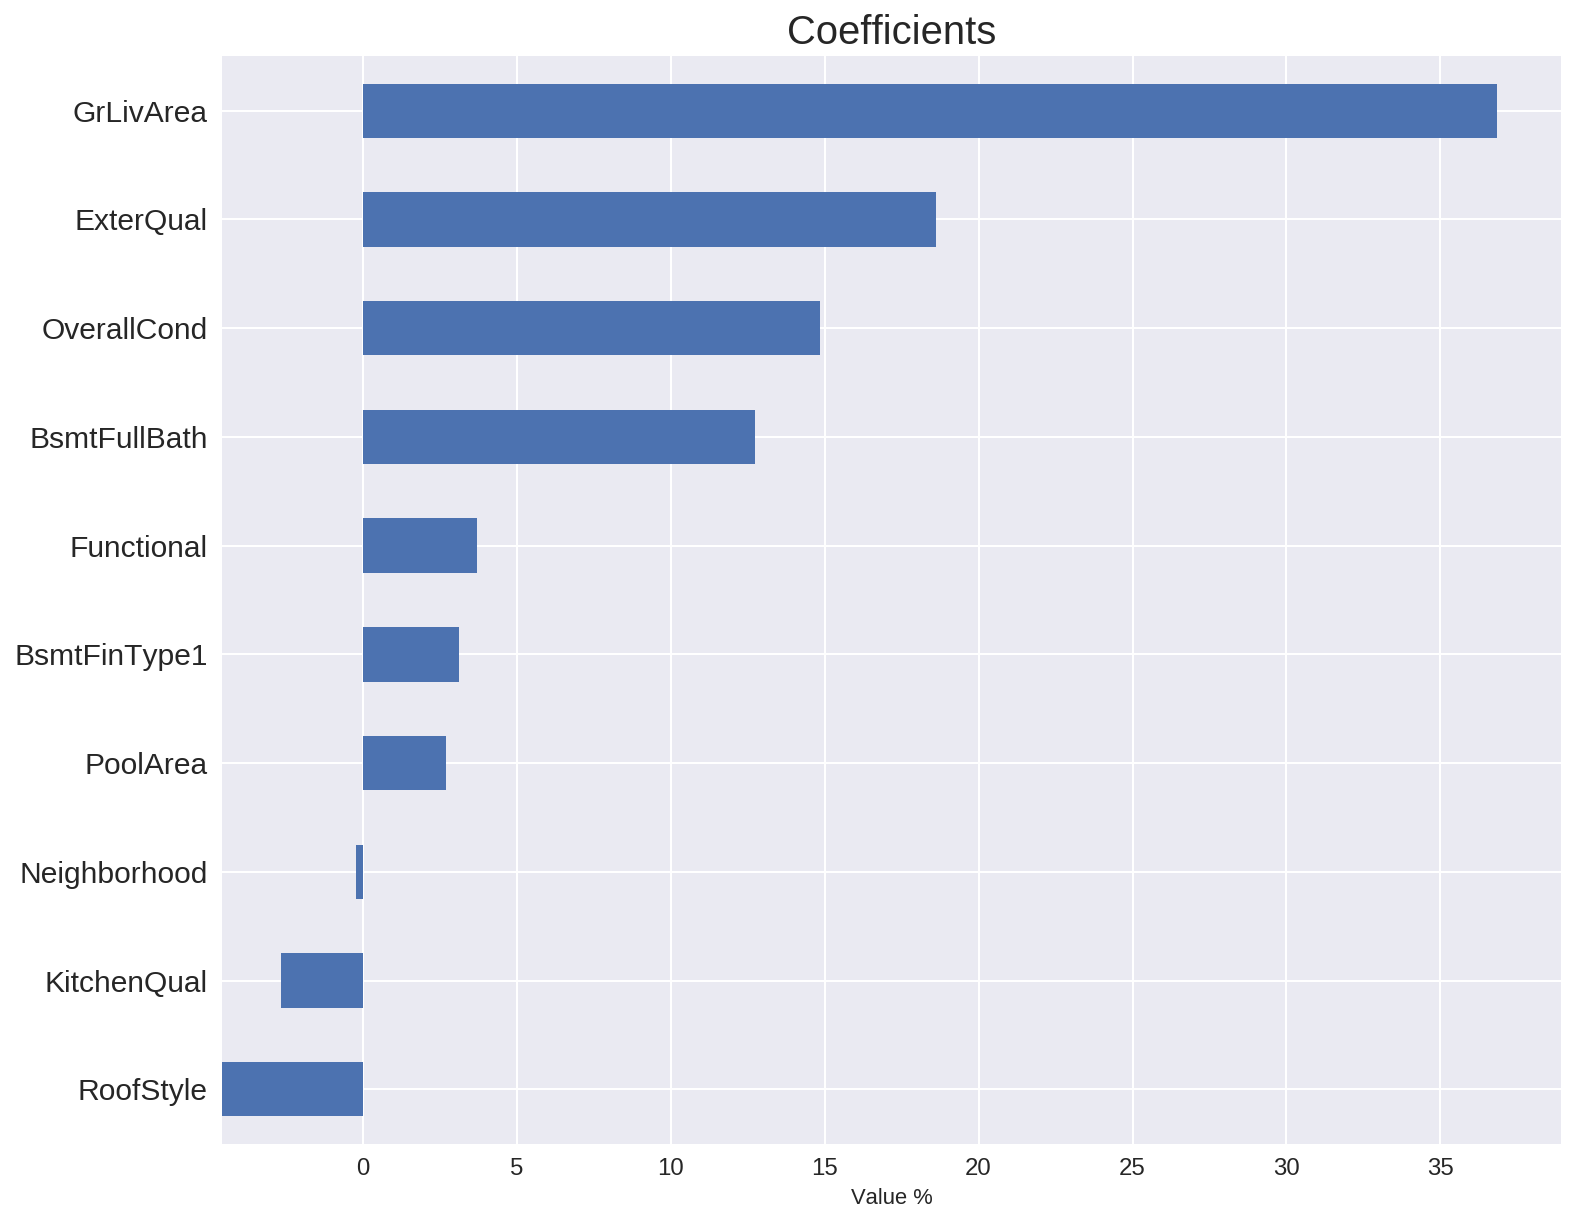

In [167]:
df_coef_el = pd.Series(dict(zip(baseprice_important, best_el.coef_)))
#print df_coef_el/(sum(abs(df_coef_el)))
el_df_coef = df_coef_el[df_coef_el != 0]
el_df_coef_normalized = 100*el_df_coef/(sum(abs(el_df_coef)))

plt.figure(figsize=(12,10))
el_df_coef_normalized.sort_values().plot(kind='barh')
plt.yticks(fontsize=15)
plt.xticks(fontsize=12)
plt.title("Coefficients", fontsize=20)
plt.xlabel("Value %")

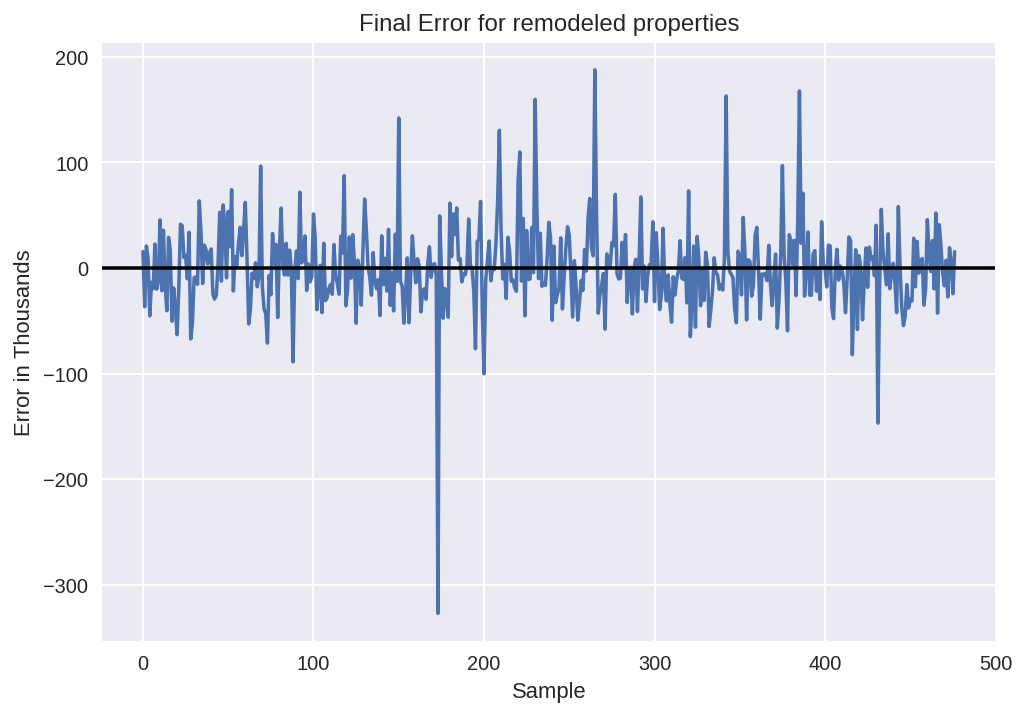

In [168]:
# Plot error
plt.plot((y_remodeled - (y_remodeled_predicted + best_el.predict(Xs_remodeled_fix_full)))/1000)
plt.title("Final Error for remodeled properties")
plt.xlabel("Sample")
plt.ylabel("Error in Thousands")
ax = plt.gca()

ax.axhline(y=(y_remodeled - (y_remodeled_predicted + best_el.predict(Xs_remodeled_fix_full))).mean()/1000, color='black')

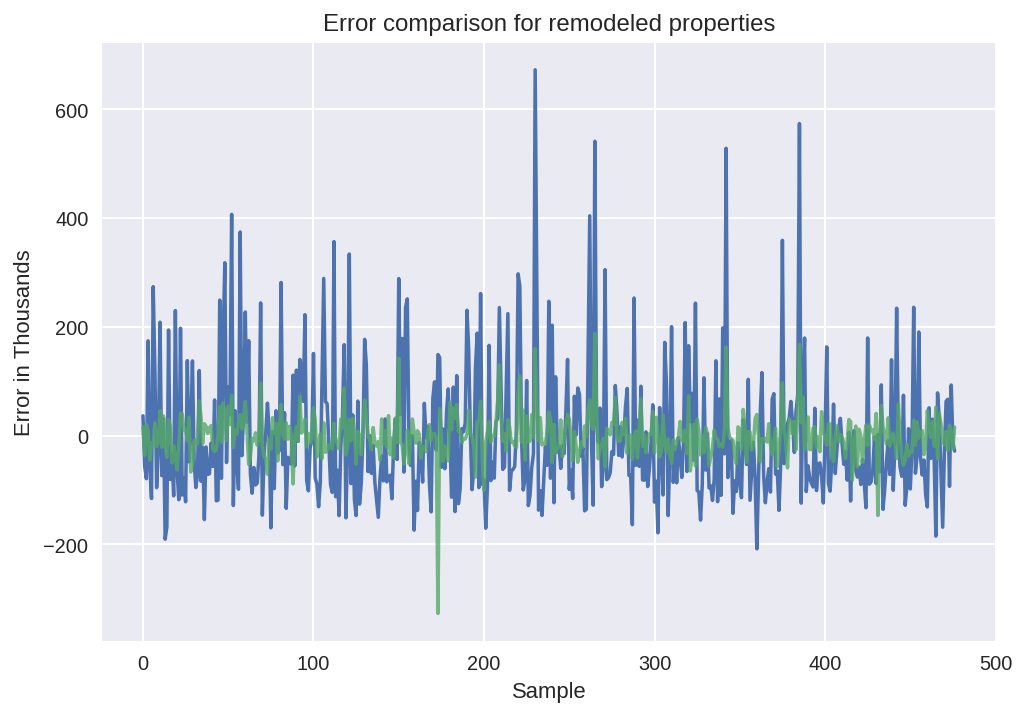

In [169]:
plt.plot((y_remodeled - y_remodeled_predicted)/1000)
plt.plot((y_remodeled - (y_remodeled_predicted + best_el.predict(Xs_remodeled_fix_full)))/1000, alpha=0.8)
plt.title("Error comparison for remodeled properties")
plt.xlabel("Sample")
plt.ylabel("Error in Thousands")

In [170]:
from sklearn.metrics import r2_score

r2_score(y_remodeled, y_remodeled_predicted + best_el.predict(Xs_remodeled_fix_full))

0.80807794369253061

In [223]:
#############
# Test Data #
#############
# ss -> ls_d -> best_el

In [171]:
################
# Categorizing #
################
categorical_columns = hs_2010.select_dtypes(include=['object']).columns.values
for c in categorical_columns:
    hs_2010[c] = hs_2010[c].astype('category').cat.codes

In [188]:
################
# Standarizing #
################
X_2010_remodeled, X_2010_nremodeled, y_2010_remodeled, y_2010_nremodeled = \
split_years(hs_2010)

# Pick columns used before
X_2010_remodeled_1 = X_2010_remodeled[baseprice_important]
X_2010_nremodeled = X_2010_nremodeled[baseprice_important]
#X_2010_nremodeled = X_2010_remodeled[improvement_important]

Xs_2010_remodeled = ss.fit_transform(X_2010_remodeled_1)
Xs_2010_nremodeled = ss.fit_transform(X_2010_nremodeled)

print X_2010_remodeled_1.shape, len(y_2010_remodeled)
print X_2010_nremodeled.shape, len(y_2010_nremodeled)

(64, 20) 64
(68, 20) 68


In [189]:
# Get predictions for remodeled and not remodeled
y_remodeled_predicted = ls_d.predict(Xs_2010_remodeled)
y_nremodeled_predicted = ls_d.predict(Xs_2010_nremodeled)

In [190]:
X_2010_remodeled_aux = X_2010_remodeled[improvement_important]
X_2010_remodeled_aux_full = pd.concat([X_2010_remodeled[improvements], \
                                        pd.DataFrame(y_remodeled_predicted,\
                                                     columns=['y_predicted'])],axis=1)
Xs_2010_remodeled_aux_full = ss.fit_transform(X_2010_remodeled_aux_full)

In [191]:
y_remodeled_predicted_final = best_el.predict(Xs_2010_remodeled_aux_full)

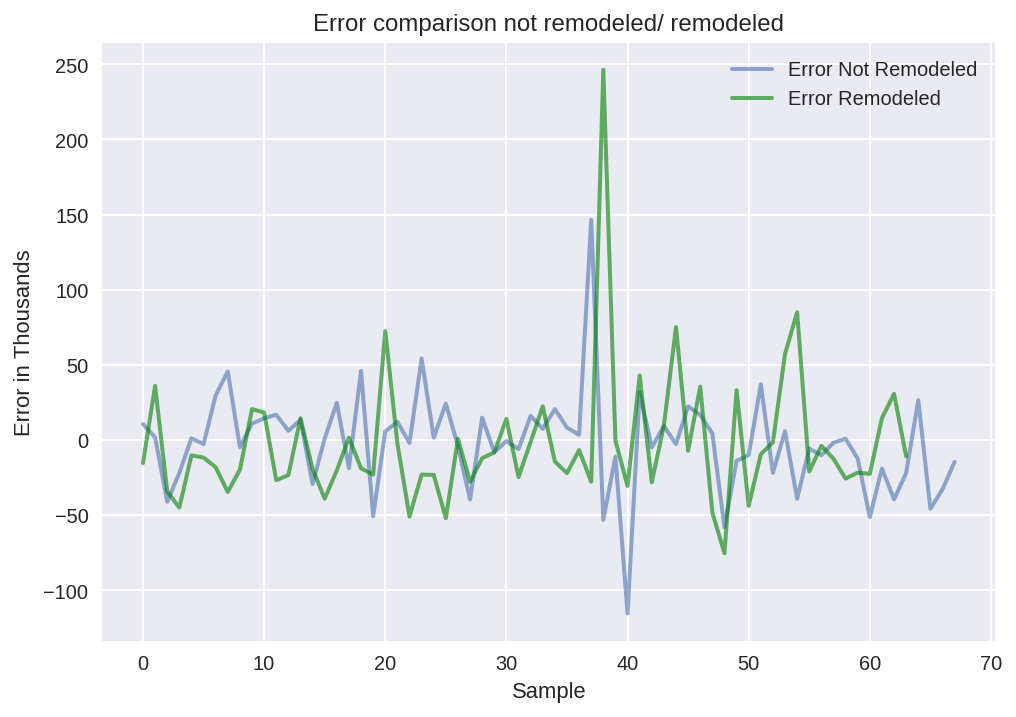

In [230]:
plt.plot((y_2010_nremodeled - y_nremodeled_predicted)/1000, alpha=0.6,\
         lw = 2, label='Error Not Remodeled')
plt.plot((y_2010_remodeled - y_remodeled_predicted)/1000, alpha=0.6,lw=2, \
         color='g',label='Error Remodeled')

#pd.concat([pd.Series((y_2010_nremodeled - y_nremodeled_predicted)/1000), \
#           pd.Series((y_2010_remodeled - y_remodeled_predicted)/1000)],axis=1).\
#plot(kind='bar',label='Error Remodeled', stacked=True)
plt.title("Error comparison not remodeled/ remodeled")
plt.xlabel("Sample")
plt.ylabel("Error in Thousands")
plt.legend()

Not remodeled
0.774748766306
Remodeled, first prediction
0.821741422166
Remodeled, last prediction
0.887011458574


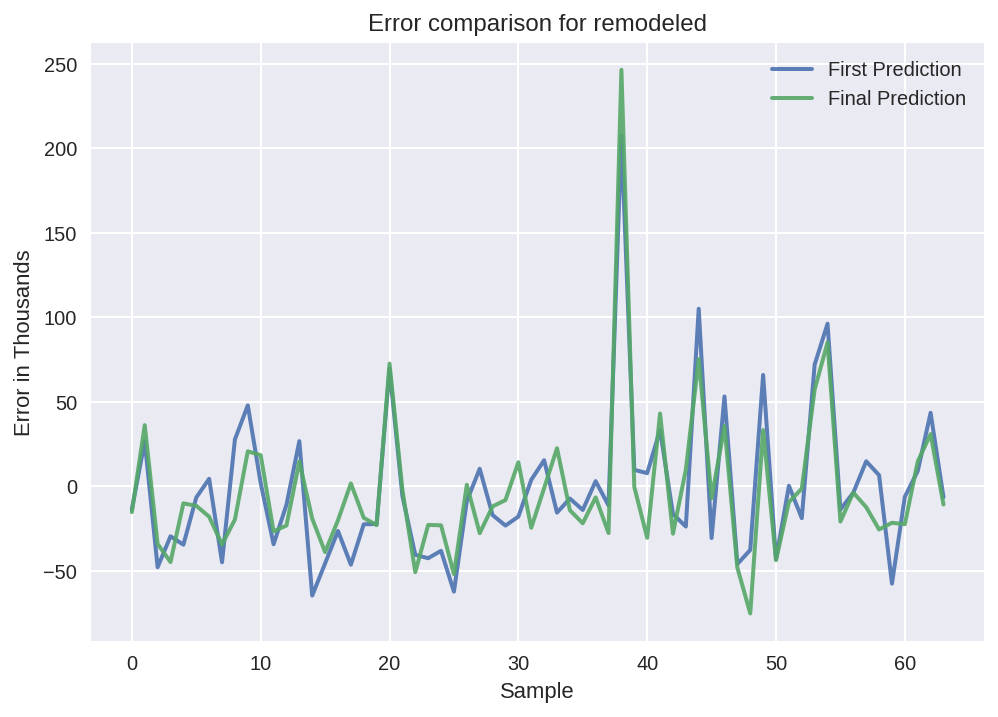

In [239]:
plt.plot((y_2010_remodeled - (y_remodeled_predicted + y_remodeled_predicted_final))/1000,\
         lw = 2,alpha=0.9,label='First Prediction')
plt.plot((y_2010_remodeled - y_remodeled_predicted)/1000, alpha=0.9,\
         lw = 2, label='Final Prediction')

plt.title("Error comparison for remodeled")
plt.xlabel("Sample")
plt.ylabel("Error in Thousands")
plt.legend()

print "Not remodeled"
print cross_val_score(ls_d, Xs_2010_nremodeled, y_2010_nremodeled, cv=5).mean()
print "Remodeled, first prediction"
print cross_val_score(ls_d, Xs_2010_remodeled, y_2010_remodeled, cv=5).mean()
print "Remodeled, last prediction"
print cross_val_score(best_el, Xs_2010_remodeled_aux_full, y_2010_remodeled, cv=5).mean()

In [325]:
pd.DataFrame(pd.Series({'Not remodeled':0.775, 'Remodeled, first prediction':0.82, \
           'Remodeled, last prediction':0.887}),columns=['Error'])

,Error
Not remodeled,0.775
"Remodeled, first prediction",0.820
"Remodeled, last prediction",0.887


<img src="http://imgur.com/l5NasQj.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

## 2. Determine any value of *changeable* property characteristics unexplained by the *fixed* ones.

---

Now that you have a model that estimates the price of a house based on its static characteristics, we can move forward with part 2 and 3 of the plan: what are the costs/benefits of quality, condition, and renovations?

There are two specific requirements for these estimates:
1. The estimates of effects must be in terms of dollars added or subtracted from the house value. 
2. The effects must be on the variance in price remaining from the first model.

The residuals from the first model (training and testing) represent the variance in price unexplained by the fixed characteristics. Of that variance in price remaining, how much of it can be explained by the easy-to-change aspects of the property?

---

**Your goals:**
1. Evaluate the effect in dollars of the renovate-able features. 
- How would your company use this second model and its coefficients to determine whether they should buy a property or not? Explain how the company can use the two models you have built to determine if they can make money. 
- Investigate how much of the variance in price remaining is explained by these features.
- Do you trust your model? Should it be used to evaluate which properties to buy and fix up?

<img src="http://imgur.com/GCAf1UX.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

## 3. What property characteristics predict an "abnormal" sale?

---

The `SaleCondition` feature indicates the circumstances of the house sale. From the data file, we can see that the possibilities are:

       Normal	Normal Sale
       Abnorml	Abnormal Sale -  trade, foreclosure, short sale
       AdjLand	Adjoining Land Purchase
       Alloca	Allocation - two linked properties with separate deeds, typically condo with a garage unit	
       Family	Sale between family members
       Partial	Home was not completed when last assessed (associated with New Homes)
       
One of the executives at your company has an "in" with higher-ups at the major regional bank. His friends at the bank have made him a proposal: if he can reliably indicate what features, if any, predict "abnormal" sales (foreclosures, short sales, etc.), then in return the bank will give him first dibs on the pre-auction purchase of those properties (at a dirt-cheap price).

He has tasked you with determining (and adequately validating) which features of a property predict this type of sale. 

---

**Your task:**
1. Determine which features predict the `Abnorml` category in the `SaleCondition` feature.
- Justify your results.

This is a challenging task that tests your ability to perform classification analysis in the face of severe class imbalance. You may find that simply running a classifier on the full dataset to predict the category ends up useless: when there is bad class imbalance classifiers often tend to simply guess the majority class.

It is up to you to determine how you will tackle this problem. I recommend doing some research to find out how others have dealt with the problem in the past. Make sure to justify your solution. Don't worry about it being "the best" solution, but be rigorous.

Be sure to indicate which features are predictive (if any) and whether they are positive or negative predictors of abnormal sales.

In [20]:
print hs['SaleCondition'].value_counts()
#hs_ab = hs[hs['SaleCondition'] == 'Abnorml']
#hs_ab.head()

# Assemble two classes

# Vary Threshold and see result 

# Bootstrap

# Undersample main class

# lr for each bootstrap

# lr mean

# Evaluate with F1 score


Normal     787
Partial    113
Abnorml     62
Family      16
Alloca       8
AdjLand      1
Name: SaleCondition, dtype: int64


In [21]:
hs['SaleCondition'] = hs['SaleCondition'].apply(lambda s: 1 if s == 'Abnorml' else 0)

In [22]:
# Create two classes
print hs['SaleCondition'].value_counts()
print 'baseline', hs['SaleCondition'].mean()

0    925
1     62
Name: SaleCondition, dtype: int64
baseline 0.0628166160081


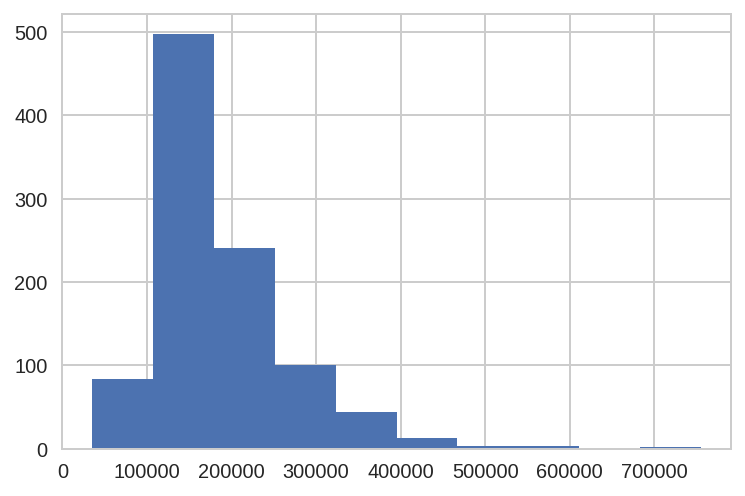

In [35]:
# EDA
hs['SalePrice'].hist()

In [40]:
sc = hs[hs['SaleCondition']==1]

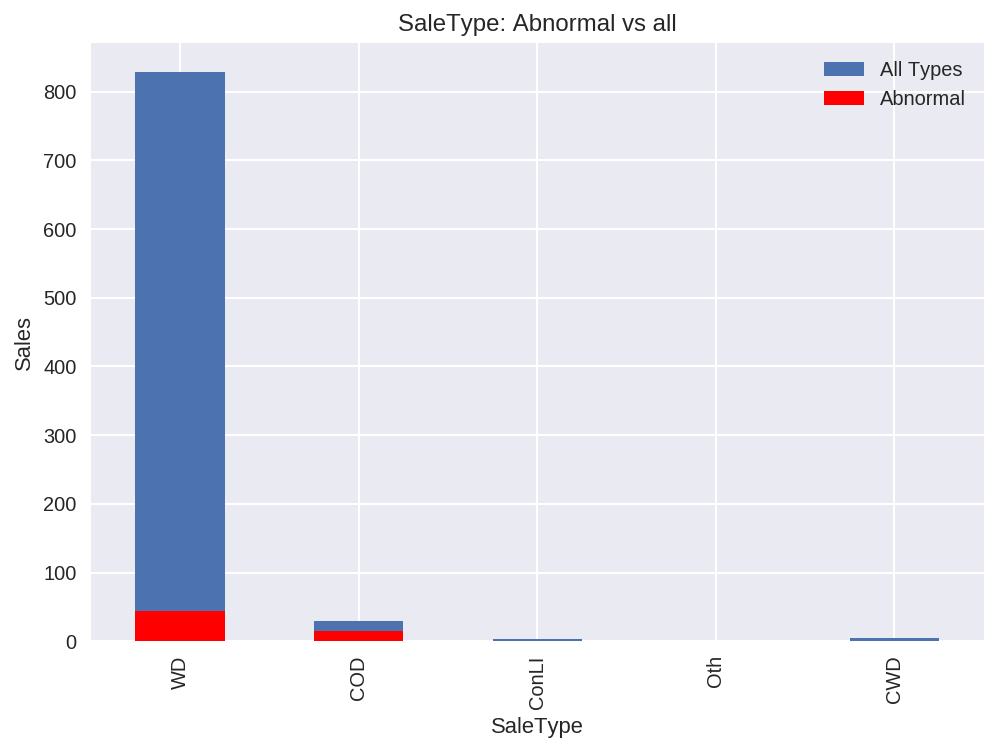

In [117]:
var = 'SaleType'
# 'SaleType'
hs[var].value_counts()[sc[var].value_counts().index].plot(kind='bar', label='All Types')
sc[var].value_counts().plot(kind='bar', color='r', label='Abnormal')

plt.title("SaleType: Abnormal vs all")
plt.xlabel("SaleType")
plt.ylabel("Sales")
plt.legend()

In [104]:
sc['SaleType'].value_counts()
hs['SaleType'].value_counts()[sc['SaleType'].value_counts().index]

WD       44
COD      15
ConLI     1
Oth       1
CWD       1
Name: SaleType, dtype: int64
WD       829
COD       29
ConLI      3
Oth        1
CWD        4
Name: SaleType, dtype: int64


In [99]:
15./29

0.5172413793103449

In [28]:
hs.columns

Index([u'index', u'Id', u'MSSubClass', u'MSZoning', u'LotFrontage', u'LotArea',
       u'Street', u'Alley', u'LotShape', u'LandContour', u'Utilities',
       u'LotConfig', u'LandSlope', u'Neighborhood', u'Condition1',
       u'Condition2', u'BldgType', u'HouseStyle', u'OverallQual',
       u'OverallCond', u'YearBuilt', u'YearRemodAdd', u'RoofStyle',
       u'RoofMatl', u'Exterior1st', u'Exterior2nd', u'MasVnrType',
       u'MasVnrArea', u'ExterQual', u'ExterCond', u'Foundation', u'BsmtQual',
       u'BsmtCond', u'BsmtExposure', u'BsmtFinType1', u'BsmtFinSF1',
       u'BsmtFinType2', u'BsmtFinSF2', u'BsmtUnfSF', u'TotalBsmtSF',
       u'Heating', u'HeatingQC', u'CentralAir', u'Electrical', u'1stFlrSF',
       u'2ndFlrSF', u'LowQualFinSF', u'GrLivArea', u'BsmtFullBath',
       u'BsmtHalfBath', u'FullBath', u'HalfBath', u'BedroomAbvGr',
       u'KitchenAbvGr', u'KitchenQual', u'TotRmsAbvGrd', u'Functional',
       u'Fireplaces', u'FireplaceQu', u'GarageType', u'GarageYrBlt',
       u'Gara

In [25]:
# Set up variables
X3 = hs[[c for c in hs.columns.values if c not in ['SaleCondition', 'index', 'Id']]].copy()
y3 = hs['SaleCondition'].values

In [66]:
categorical_columns_3

array(['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour',
       'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1',
       'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl',
       'Exterior1st', 'Exterior2nd', 'MasVnrType', 'ExterQual',
       'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure',
       'BsmtFinType1', 'BsmtFinType2', 'Heating', 'HeatingQC',
       'CentralAir', 'Electrical', 'KitchenQual', 'Functional',
       'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual',
       'GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 'MiscFeature',
       'SaleType'], dtype=object)

In [26]:
categorical_columns_3 = X3.select_dtypes(include=['object']).columns.values
for c in categorical_columns_3:
    X3.loc[:,c] = X3.loc[:,c].astype('category').cat.codes

In [27]:
print X3.dtypes.value_counts()

int8       42
int64      34
float64     3
dtype: int64


In [121]:
# Scale input
from sklearn.preprocessing import StandardScaler
ss = StandardScaler()
Xs3 = ss.fit_transform(X3,y3)

In [120]:
# For the one correcting this, I did 3 approaches. Skip to the 'best' one (last one)
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix

def lr_cv(X3,y3, C, threshold=0.5):
    '''
    Returns best F1 score
    '''
    F1s = []
    for c in C:
        lg = LogisticRegression(C=c)
        lg.fit(X3,y3)
        predicted = [1 if n > threshold else 0 for n in lg.predict_proba(X3)[:,1]]
        cm = confusion_matrix(y3, predicted)
        if cm[1][1] == 0:
            recall = 0
            precision = 0
            F1 = 0
        else:
            recall = float(cm[1][1]) / (cm[0][1] + cm[1][1])
            precision = float(cm[1][1]) / (cm[1][0] + cm[1][1])
            F1 = 2 * recall * precision / (recall + precision)
        F1s.append(F1)  
    return F1s

C = np.linspace(1,1000,200)
lr_cv(X3,y3, C)

None

In [275]:
# Loop for different thresholds and then different C
C = np.linspace(50000,100000,200)
thresholds = np.linspace(0,1,50)
F1_maxs = []
for i,threshold in enumerate(thresholds):
    if not (float(i)/len(thresholds)*100 % 10):
            print float(i)/len(thresholds)*100 + 10
    F1_max = lr_cv(X3,y3, C, threshold)
    F1_maxs.append(F1_max)

10.0
20.0
30.0
40.0
50.0
60.0
70.0
80.0
90.0
100.0


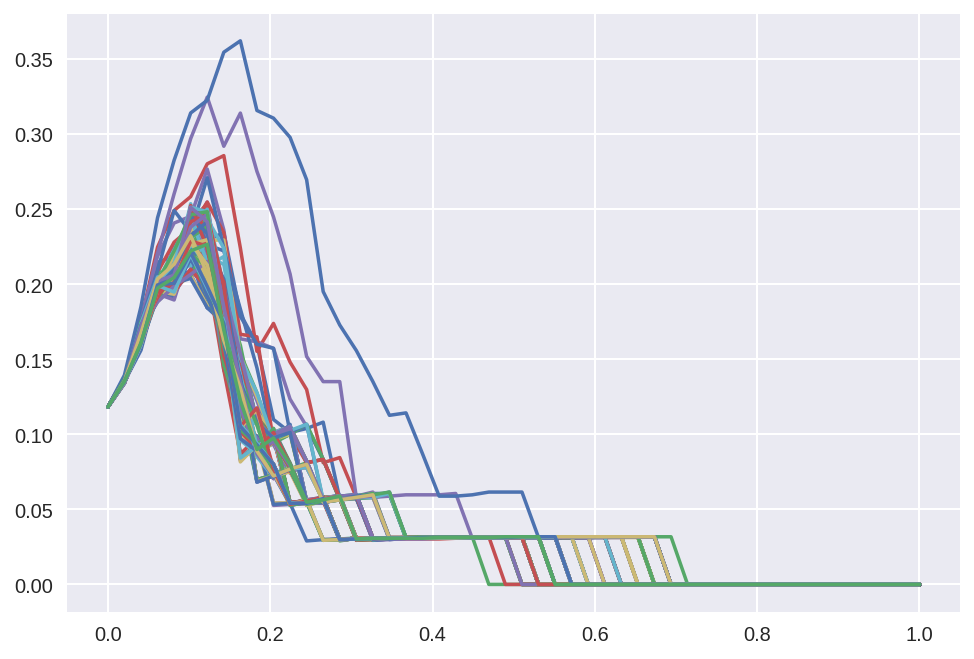

In [262]:
# Overlapped plot
plt.plot(thresholds, F1_maxs)

In [276]:
FF = np.array(F1_maxs)

print FF.shape

(50, 200)


(200, 50) (200, 50)


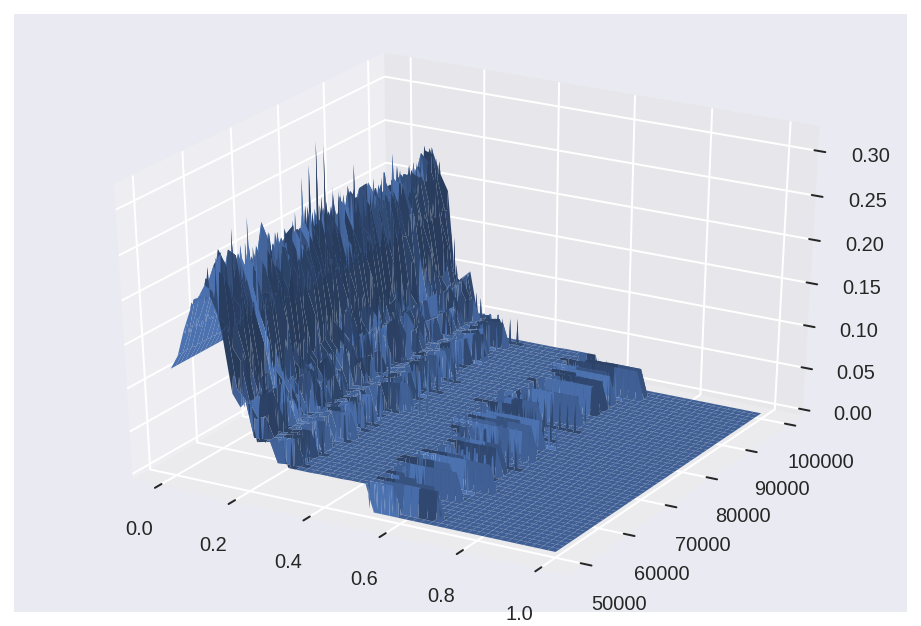

In [277]:
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

xs = thresholds
ys = C
xs, ys = np.meshgrid(xs, ys)
print xs.shape, ys.shape
ax.plot_surface(xs, ys, FF.T)

In [281]:
XX = hs[[c for c in hs.columns.values if c not in ['index', 'Id']]]

In [122]:
from sklearn.model_selection import cross_val_score
def lr_cv_score(X,y,C):
    scores = []
    for c in C:
        lr = LogisticRegression(C=c)
        lr.fit(X,y)
        score = cross_val_score(lr, X, y, cv=5).mean()
        scores.append(score)
        score_ix = scores.index(max(scores))
    return C[score_ix]

In [283]:
Cs=[]
for _ in range(25):
    XX2 = XX.sample(n=len(XX), replace=True)

    n_rare = XX2['SaleCondition'].value_counts()[1]
    #print n_rare
    XX_rare = XX2[XX2['SaleCondition'] == 1]
    XX_not_rare =  XX2[XX2['SaleCondition'] != 1][0:n_rare]

    XX2 = pd.concat([XX_rare,XX_not_rare])
    #print XX.shape

    X4 = XX2[[c for c in XX.columns.values if c != 'SaleCondition']]
    y4 = XX2['SaleCondition'].values
    #print 'baseline', XX['SaleCondition'].mean()
    
    categorical_columns_4 = X4.select_dtypes(include=['object']).columns.values
    for c in categorical_columns_4:
        X4.loc[:,c] = X4.loc[:,c].astype('category').cat.codes
    Xs4 = ss.fit_transform(X4)
    
    C = np.linspace(0.0000001,100,100)
    C_best = lr_cv_score(X4,y4, C)
    Cs.append(C_best)


42.9494950065


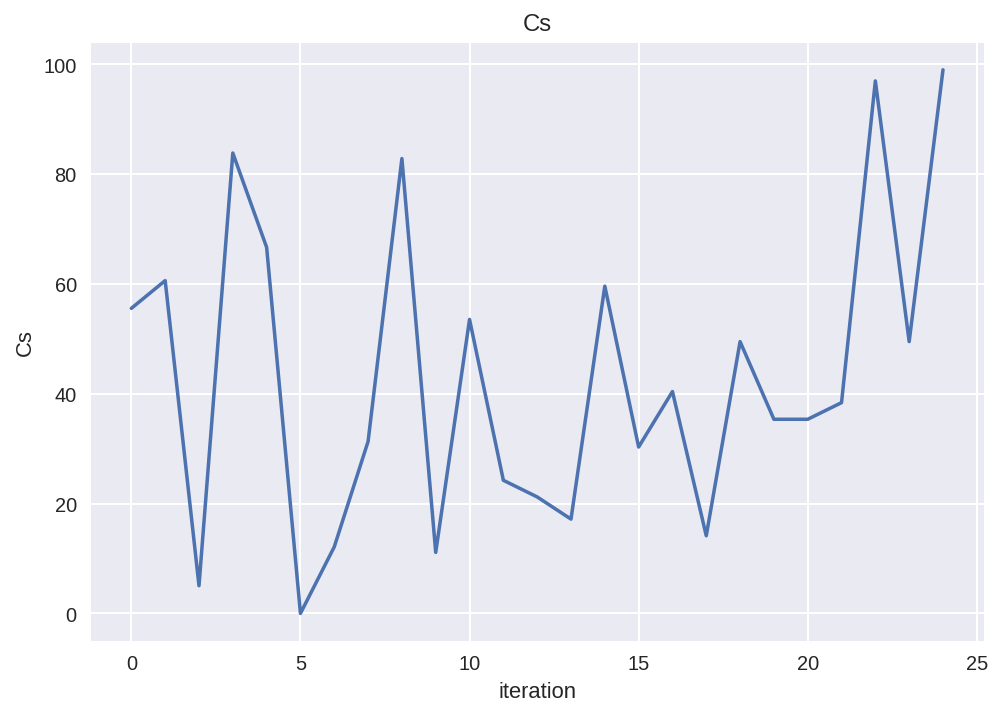

In [285]:
#sns.set(font_scale=1)
plt.plot(Cs)
plt.title("Cs")
plt.xlabel("iteration")
plt.ylabel("Cs")
print np.mean(Cs)

In [123]:
lr = LogisticRegression(C=np.mean(Cs))
lr.fit(X3,y3)
cfm = confusion_matrix(y3, lr.predict(X3))

NameError: name 'Cs' is not defined

In [287]:
from sklearn.metrics import f1_score
print cfm
print 'F1 score', f1_score(y3, lr.predict(X3))

[[925   0]
 [ 61   1]]
F1 score 0.031746031746


In [124]:
# class weights!
from sklearn.model_selection import GridSearchCV
params ={
    'C': np.linspace(1,1500,50),
    'class_weight': [{1: w, 0:1} for w in range(2,40,2)]
}
lr = LogisticRegression()
gr = GridSearchCV(lr, params, scoring='f1')
gr.fit(X3,y3)

KeyboardInterrupt: 

In [289]:
print gr.best_params_, gr.best_score_

{'C': 368.10204081632651, 'class_weight': {0: 1, 1: 4}} 0.293771409273


In [290]:
print confusion_matrix(y3, gr.predict(X3))
print f1_score(y3, gr.predict(X3))

[[898  27]
 [ 42  20]]
0.366972477064


In [299]:
lr.set_params(C=gr.best_params_['C'], class_weight=gr.best_params_['class_weight'])
lr.fit(X3,y3)

LogisticRegression(C=368.10204081632651, class_weight={0: 1, 1: 4},
          dual=False, fit_intercept=True, intercept_scaling=1,
          max_iter=100, multi_class='ovr', n_jobs=1, penalty='l2',
          random_state=None, solver='liblinear', tol=0.0001, verbose=0,
          warm_start=False)

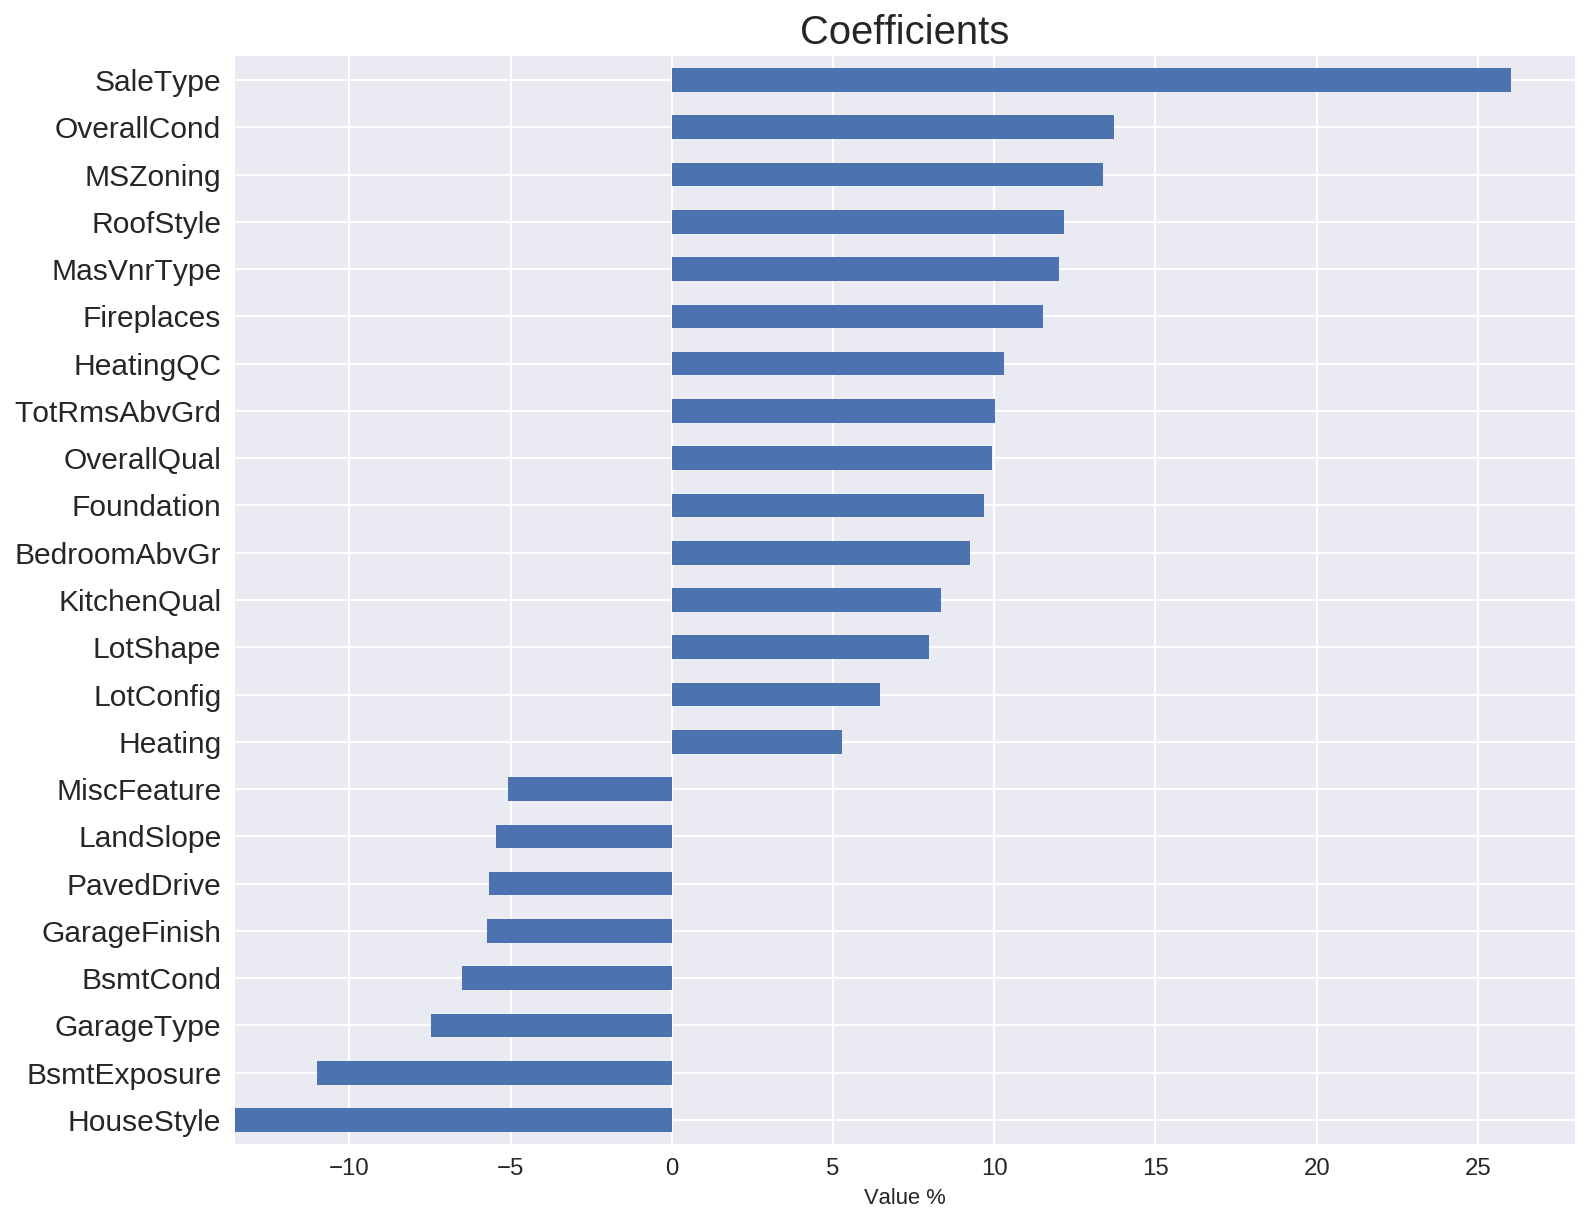

In [319]:
rare = pd.Series(dict(zip(X3.columns,*lr.coef_)))
rare = 100*rare / sum(rare)

plt.figure(figsize=(12,10))
rare[abs(rare) > 5].sort_values().plot(kind='barh')

plt.yticks(fontsize=15)
plt.xticks(fontsize=12)
plt.title("Coefficients", fontsize=20)
plt.xlabel("Value %")

In [195]:
# Best solution so far
from sklearn.model_selection import GridSearchCV
params ={
    'C': np.linspace(1,1500,50),
    'class_weight': [{1: w, 0:1} for w in range(2,40,2)]
}
lr = LogisticRegression()
gr = GridSearchCV(lr, params, scoring='f1', cv=5)
gr.fit(Xs3,y3)

GridSearchCV(cv=5, error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'C': array([  1.00000e+00,   3.15918e+01,   6.21837e+01,   9.27755e+01,
         1.23367e+02,   1.53959e+02,   1.84551e+02,   2.15143e+02,
         2.45735e+02,   2.76327e+02,   3.06918e+02,   3.37510e+02,
         3.68102e+02,   3.98694e+02,   4.29286e+02,   4.59878e+02,
         4.9046..., 1: 26}, {0: 1, 1: 28}, {0: 1, 1: 30}, {0: 1, 1: 32}, {0: 1, 1: 34}, {0: 1, 1: 36}, {0: 1, 1: 38}]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='f1', verbose=0)

In [196]:
from sklearn.metrics import classification_report
print confusion_matrix(y3, gr.predict(Xs3))
print classification_report(y3, gr.predict(Xs3))

[[830  95]
 [ 16  46]]
             precision    recall  f1-score   support

          0       0.98      0.90      0.94       925
          1       0.33      0.74      0.45        62

avg / total       0.94      0.89      0.91       987



In [134]:
# For recall scoring
a = pd.DataFrame(columns=['Predicted Not Abnormal', 'Predicted Abnormal'], index=['Not Abnormal', 'Abnormal'])
a.ix[0,:] = [671, 254]
a.ix[1,:] = [1, 61]
a

,Predicted Not Abnormal,Predicted Abnormal
Not Abnormal,671,254
Abnormal,1,61


In [191]:
print gr.best_params_, gr.best_score_

{'C': 31.591836734693878, 'class_weight': {0: 1, 1: 32}} 0.514229859975


In [197]:
#lr.set_params(C=0.1, class_weight={0: 1, 1: 24})
lr.set_params(C=gr.best_params_['C'], class_weight=gr.best_params_['class_weight'])
lr.fit(Xs3,y3)

LogisticRegression(C=31.591836734693878, class_weight={0: 1, 1: 8},
          dual=False, fit_intercept=True, intercept_scaling=1,
          max_iter=100, multi_class='ovr', n_jobs=1, penalty='l2',
          random_state=None, solver='liblinear', tol=0.0001, verbose=0,
          warm_start=False)

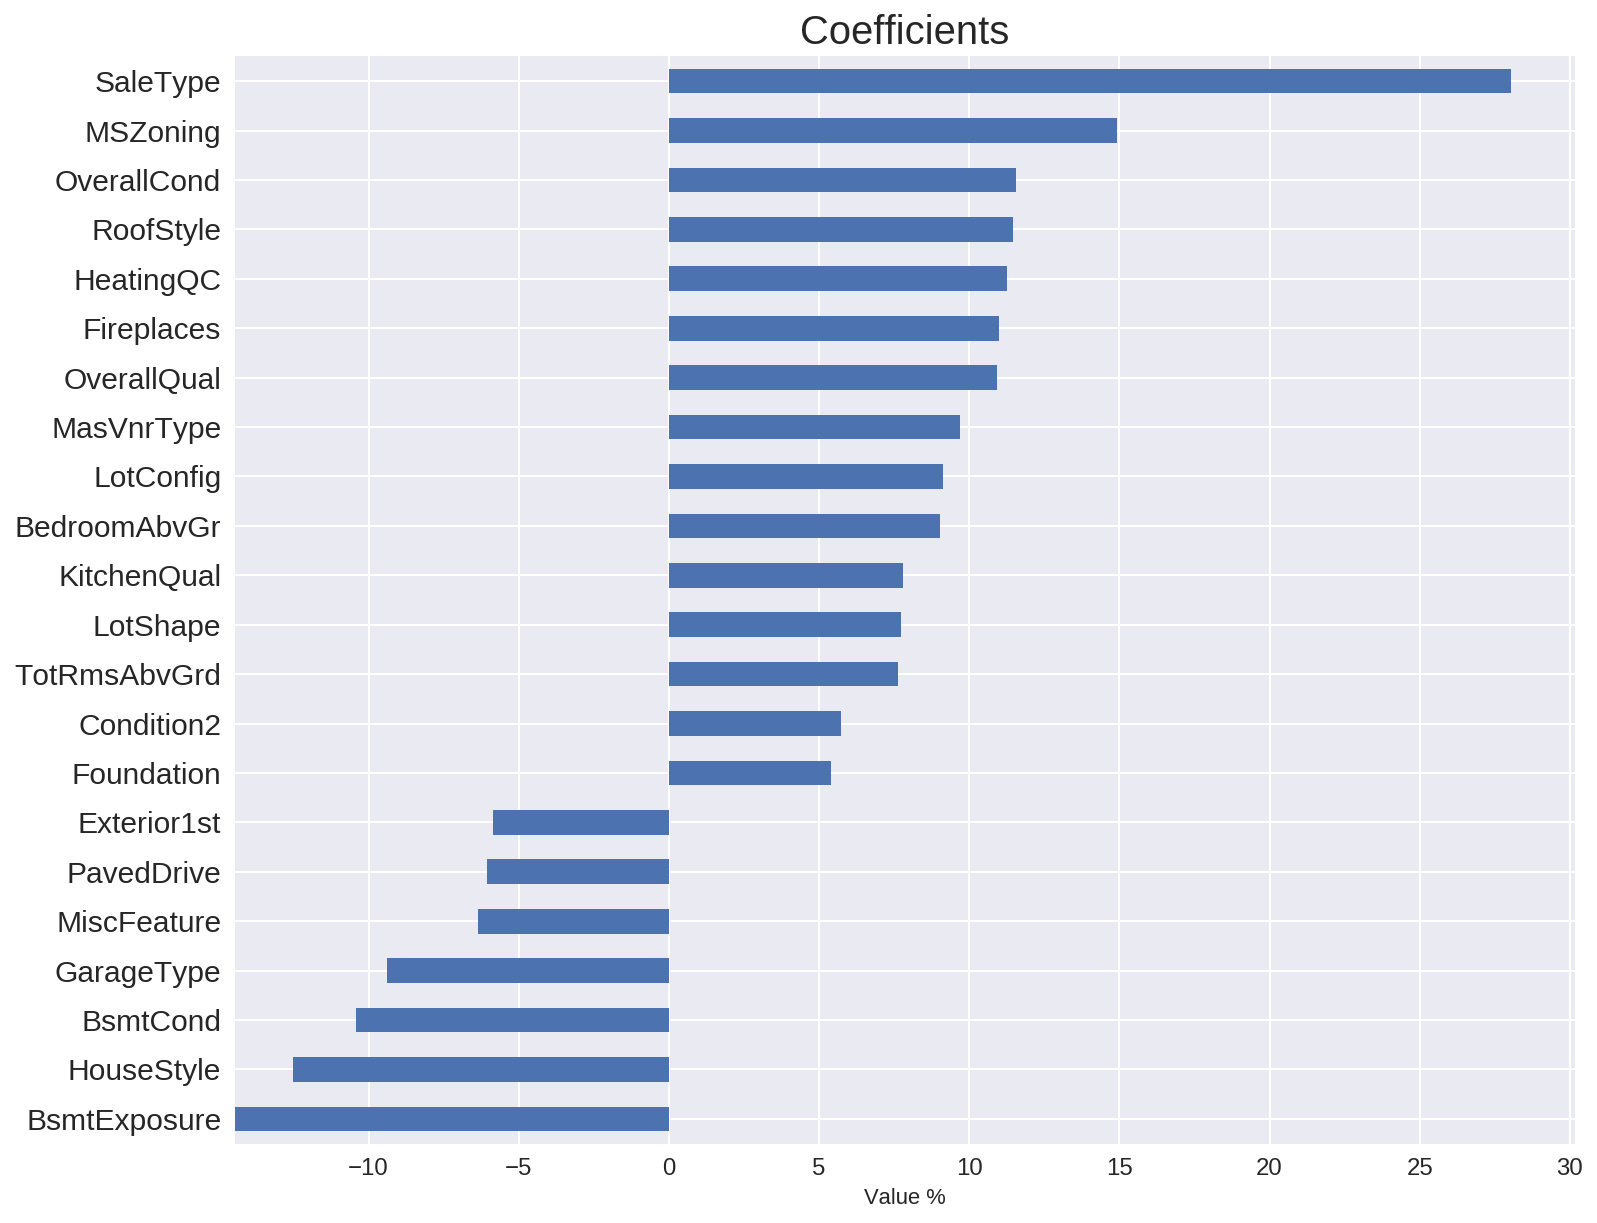

In [324]:
rare = pd.Series(dict(zip(X3.columns,*lr.coef_)))
rare = 100*rare / sum(rare)

plt.figure(figsize=(12,10))
rare[abs(rare) > 5].sort_values().plot(kind='barh')

plt.yticks(fontsize=15)
plt.xticks(fontsize=12)
plt.title("Coefficients", fontsize=20)
plt.xlabel("Value %")

In [141]:
hs_2010['SaleCondition'] = hs_2010['SaleCondition'].apply(lambda s: 1 if s == 'Abnorml' else 0)
X5 = hs_2010[[c for c in hs.columns.values if c not in ['SaleCondition', 'index', 'Id']]].copy()
y5 = hs_2010['SaleCondition'].values

In [142]:
categorical_columns_5 = X5.select_dtypes(include=['object']).columns.values
for c in categorical_columns_5:
    X5.loc[:,c] = X5.loc[:,c].astype('category').cat.codes

In [155]:
Xs5 = ss.transform(X5)

In [199]:
print confusion_matrix(y5, lr.predict(Xs5))
print classification_report(y5, lr.predict(Xs5))

[[  0 123]
 [  0   9]]
             precision    recall  f1-score   support

          0       0.00      0.00      0.00       123
          1       0.07      1.00      0.13         9

avg / total       0.00      0.07      0.01       132

